In [ ]:
!pip install transformers[torch]
!pip install sentencepiece
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 58.0 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.1 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 140 kB 59.0 MB/s 
     |████████████████████████████████| 1.1 MB 55.2 MB/s 
     |████████████████████████████████|

In [ ]:
dataset_base = "drive/MyDrive/nlp_lss_data/"
# dataset_base = "/toshiba/nlp_lss_data/"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from datasets import load_dataset,DatasetDict,Dataset
# from datasets import 
from transformers import AutoTokenizer
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import torch 

In [2]:
import torch
from transformers import BertModel, BertConfig, PretrainedConfig, PreTrainedModel, AutoModel, AutoConfig
from typing import List, Optional, Tuple, Union
from transformers.modeling_outputs import TokenClassifierOutput,SequenceClassifierOutput
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, BCELoss
import torch.nn as nn

# weight = torch.FloatTensor(compute_class_weight(class_weight="balanced", classes=[0, 1], y=df_train["truthClass"])).to('cpu')
# WEIGHT = torch.cuda.FloatTensor([weight[1]/weight[0]])

class ClickbaitConfig(PretrainedConfig):
    def __init__(
        self,
        model_type: str = "bert",
        pretrained_model: str = "bert-base-uncased",
        num_labels: int = 2,
        dropout: float = 0.1,
        inner_dim1: int = 256,
        inner_dim2: int = 32, 
        max_length: int = 512,
        load_pretrained: bool = True,
        freeze_bert: bool = True,
        **kwargs
    ):
        super(ClickbaitConfig, self).__init__(num_labels=num_labels, **kwargs)
        self.model_type = model_type
        self.pretrained_model = pretrained_model
        self.dropout = dropout
        self.inner_dim1 = inner_dim1
        self.inner_dim2 = inner_dim2
        self.max_length = max_length
        self.load_pretrained = load_pretrained
        self.freeze_bert = freeze_bert


class BertClickbaitClassifier(PreTrainedModel):
    """
      Taken and extended from BertforSequenceClassification : https://github.com/huggingface/transformers/blob/v4.19.2/src/transformers/models/bert/modeling_bert.py#L1508
    """
    config_class = ClickbaitConfig
    def __init__(self, config: ClickbaitConfig):
        super(BertClickbaitClassifier, self).__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        # self.bert_config = BertConfig.from_pretrained(config.pretrained_model)
        self.bert_config = AutoConfig.from_pretrained(config.pretrained_model)

        # self.bert = BertModel(self.bert_config)
        self.bert = AutoModel.from_pretrained(config.pretrained_model, config=self.bert_config)
        if config.load_pretrained:
            print("Load pretrained weights from {}".format(config.pretrained_model))
            self.bert = self.bert.from_pretrained(config.pretrained_model)
        if config.freeze_bert:
            print("Freeze weights in the BERT model. Just the classifier will be trained")
            for param in self.bert.parameters():
                param.requires_grad = False

        self.linear_1 = nn.Linear(self.bert.config.hidden_size, config.inner_dim1)
        self.dropout_1 = nn.Dropout(config.dropout) 
        self.relu_1 = nn.ReLU()
        self.dropout_2 = nn.Dropout(config.dropout)
        self.linear_2 = nn.Linear(config.inner_dim1, config.inner_dim2)
        self.relu_2 = nn.ReLU()
        self.dropout_3 = nn.Dropout(config.dropout)
        self.classifier = nn.Linear(config.inner_dim2, config.num_labels)
        self.sigmoid = nn.Sigmoid()


    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        output = outputs[0][:,0,:]

        x = self.dropout_1(output)
        x = self.linear_1(x)
        x = self.relu_1(x)
        x = self.dropout_2(x)
        x = self.linear_2(x)
        x = self.relu_2(x)
        x = self.dropout_3(x)

        logits = self.classifier(x)
        logits = self.sigmoid(logits)

        loss = None
        if labels is not None:
            loss_fct = BCELoss()
            labels = 1.0*labels
            loss = loss_fct(logits.view(-1), labels.view(-1))
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

In [3]:
from transformers import AutoModel
# classifier_model_path = "drive/MyDrive/nlp_lss_data/mpnet_clickbait_classification_maxlen25/checkpoint-1464"
classifier_model_path = "../naacl-2021-fudge-controlled-generation/ckpt/clickbait_classifier/checkpoint-1464/"
device='cuda'
#Loading classifier
classifier_tokenizer = AutoTokenizer.from_pretrained(classifier_model_path, load_best_model_at_end=True)
classifier_model = BertClickbaitClassifier.from_pretrained(classifier_model_path).to(device)


You passed along `num_labels=2` with an incompatible id to label map: {'0': 'LABEL_0'}. The number of labels wil be overwritten to 1.


Load pretrained weights from sentence-transformers/all-mpnet-base-v2


In [35]:
def rate_title(input_text, model, tokenizer, device='cuda'):
  # input_text = {
  #                 "postText": input_text['postText'],
  #                 "truthClass" : input_text['truthClass']
  #              }
  tokenized_input = preprocess_function_title_only_classification(input_text,tokenizer=tokenizer)
  # print(tokenized_input.items())
  dict_tokenized_input = {k : torch.tensor([v]).to(device) for k,v in tokenized_input.items() if k != 'labels'}
  predicted_class = float(model(**dict_tokenized_input).logits)
  actual_class = input_text['truthClass']

  # print(predicted_class, actual_class)
  return {'predicted_class' : predicted_class}

#For classification part
def preprocess_function_title_only_classification(examples,tokenizer=None):
    model_inputs = tokenizer(examples['postText'], padding="longest", truncation=True, max_length=25)
      
    model_inputs['labels'] = examples['truthClass']

    return model_inputs


In [5]:
import pandas as pd 
webis_train = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv"
webis_test = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv"
df_train = pd.read_csv(webis_train)
df_test = pd.read_csv(webis_test)

# Filter only importante variables
# df_train = df_train[['postText', 'truthClass']]
# df_test = df_test[['postText', 'truthClass']]


df_train['truthClass'] = pd.factorize(df_train['truthClass'])[0]
df_test['truthClass'] = pd.factorize(df_test['truthClass'])[0]

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 42, 
                                  stratify = df_train['truthClass'])

webis_total = DatasetDict()

webis_total['train'] = Dataset.from_pandas(df_train)
webis_total['validation'] = Dataset.from_pandas(df_valid)
webis_total['test'] = Dataset.from_pandas(df_test)


In [36]:
# def generate_bar_plot(df_generated, df_original, x_label, y_label, save_path):
#         changes_no_clickbait = df_fudge_test['clickbait_title_clickbait_score'][df_fudge_test['truthClass'] == 0] - df_fudge_test['original_title_clickbait_score'][df_fudge_test['truthClass'] == 0]
#         changes_clickbait =  df_fudge_test['clickbait_title_clickbait_score'][df_fudge_test['truthClass'] == 1] - df_fudge_test['original_title_clickbait_score'][df_fudge_test['truthClass'] == 1]

#         fig, ax = plt.subplots(2,1, figsize=(10,10))

#         ax[0].bar(np.arange(changes_no_clickbait.shape[0]), 
#                 changes_no_clickbait, 
#                 align='center', 
#                 alpha=1.0,
#                 color=(changes_no_clickbait > 0).map({True: 'g', False: 'r'}))
#         ax[0].set_title(f'MPNet classifier: Generated - Original non-clickbait, std: {round(changes_no_clickbait.std(), 3)}, mean: {round(changes_no_clickbait.mean(), 3)}',fontsize=15)
#         ax[0].set_xlabel('Sample',fontsize=15)
#         ax[0].set_ylabel('Scorer change', fontsize=15)

#         ax[1].bar(np.arange(changes_clickbait.shape[0]), 
#                 changes_clickbait, 
#                 align='center', 
#                 alpha=1.0,
#                 color=(changes_clickbait > 0).map({True: 'g', False: 'r'}))
#         ax[1].set_title(f'MPNet classifier: Generated - Original clickbait, std: {round(changes_clickbait.std(), 3)}, mean: {round(changes_clickbait.mean(), 3)}',fontsize=15)
#         ax[1].set_xlabel('Sample', fontsize=15)
#         ax[1].set_ylabel('Scorer change', fontsize=15)
#         fig.tight_layout() 


#         fig.savefig('fudge_test.png', transparent=True)

def generate_bar_plot(df_generated, df_original, df_truth, save_path):
        """Plot for generating bar plots of differences between scorer's prediction on generated and original texts"""
        changes_no_clickbait = df_generated[df_truth == 0] - df_original[df_truth == 0]
        changes_clickbait =  df_generated[df_truth == 1] - df_original[df_truth == 1]

        fig, ax = plt.subplots(3,1, figsize=(10,10))

        ax[0].bar(np.arange(changes_no_clickbait.shape[0]), 
                changes_no_clickbait, 
                align='center', 
                alpha=1.0,
                color=(changes_no_clickbait > 0).map({True: 'g', False: 'r'}))
        ax[0].set_title(f'MPNet classifier: Generated - Original non-clickbait, std: {round(changes_no_clickbait.std(), 3)}, mean: {round(changes_no_clickbait.mean(), 3)}',fontsize=15, wrap=True)
        ax[0].set_xlabel('Sample',fontsize=15)
        ax[0].set_ylabel('Scorer change', fontsize=15)

        ax[1].bar(np.arange(changes_clickbait.shape[0]), 
                changes_clickbait, 
                align='center', 
                alpha=1.0,
                color=(changes_clickbait > 0).map({True: 'g', False: 'r'}))
        ax[1].set_title(f'MPNet classifier: Generated - Original clickbait, std: {round(changes_clickbait.std(), 3)}, mean: {round(changes_clickbait.mean(), 3)}',fontsize=15,wrap=True)
        ax[1].set_xlabel('Sample', fontsize=15)
        ax[1].set_ylabel('Scorer change', fontsize=15)
        
        # final_plot = {
        #                 'generated_clickbait': df_generated[df_truth == 1],
        #                 'original_clickbait': df_original[df_truth == 1],
        #                 # 'generated_non_clickbait': df_generated[df_truth == 0],
        #                 # 'original_non_clickbait': df_original[df_truth == 0],
        #         }

        # keys = [key for key in final_plot.keys()]
        # values = [value for value in final_plot.values()]

        # for i in range(25):
        #         ax[2].bar(np.arange(len(keys)), [value[i] for value in values],
        #         width=0.2, color='b', align='center')

        # # ax[2].bar(np.arange(changes_no_clickbait.shape[0]), 
        # #         , 
        # #         align='center', 
        # #         alpha=1.0,)
        # #         # color=(changes_no_clickbait > 0).map({True: 'g', False: 'r'}))
        # ax[2].set_title(f'MPNet classifier: generated grades',fontsize=15)
        # ax[2].set_xlabel('Sample',fontsize=15)
        # ax[2].set_ylabel('Scorer change', fontsize=15)

        fig.tight_layout() 


        fig.savefig(save_path, transparent=True)

# Analyzing PPLM

In [7]:
import pandas as pd

In [8]:
!ls pplm

 df_clickbait_test
 df_clickbait_test_class_label_0.0_subset_25.csv
 df_clickbait_test_class_label_0.33_subset_25.csv
 df_clickbait_test_class_label_0.66_subset_25.csv
 df_clickbait_test_class_label_1.0_subset_25.csv
 df_clickbait_test_stepsize_0.4_subset_25.csv
 df_clickbait_test_stepsize_0.8_subset_25.csv
 df_clickbait_test_stepsize_10.0_subset_25.csv
 df_clickbait_test_stepsize_12.0_subset_25.csv
 df_clickbait_test_stepsize_1.2_subset_25.csv
 df_clickbait_test_stepsize_15.0_subset_25.csv
 df_clickbait_test_stepsize_1.6_subset_25.csv
 df_clickbait_test_stepsize_17.0_subset_25.csv
 df_clickbait_test_stepsize_20.0_subset_25.csv
 df_clickbait_test_stepsize_2.0_subset_25.csv
 df_clickbait_test_stepsize_25.0_subset_25.csv
 df_clickbait_test_stepsize_30.0_subset_25.csv
 df_clickbait_test_stepsize_40.0_subset_25.csv
 df_clickbait_test_stepsize_4.0_subset_25.csv
 df_clickbait_test_stepsize_50.0_subset_25.csv
 df_clickbait_test_stepsize_6.0_subset_25.csv
 df_clickbait_test_stepsize_8.0_subset

In [59]:
df_pplm_csv_file = pd.read_csv('pplm/df_clickbait_train.csv')

In [60]:
df_pplm_csv_file.head()

,original_title,clickbait_title,article_content,perturbed_0,perturbed_1,perturbed_2,perturbed_3,perturbed_4,unperturbed
0,The BBC's James Reynolds looks at Donald Trum...,NaN,"['Share this with', 'Email', 'Facebook', 'Mess...",The press gallery at the end of this page con...,BBC News looks at US President Donald Trump's...,"In a daily guide to the key stories, editors ...","A daily guide to the stories, newspaper headl...",US President Donald Trump has reversed his po...,The BBC's James Reynolds looks at Donald Trum...
1,President Donald Trump said on Wednesday that...,NaN,['President Donald Trump is again singling out...,"President Donald Trump, a big fan of tax prep...",President Trump on Wednesday again lashed out...,Donald Trump has once again attacked tax firm...,President Donald Trump has once again attacke...,US President Donald Trump has said his admini...,President Donald Trump said on Wednesday that...
2,"The BBC's technology editor, Gizmodo's tech c...",NaN,['Around the Christmas period you may have not...,A selection of letters and photographs from t...,"BBC News: ""TfL'sWiFi experiment backfires"", '...",In the latest instalment of our series of let...,A quick round-up of some of the week's news- ...,A daily guide to the most read and commented-...,"The BBC's technology editor, Gizmodo's tech c..."
3,The problem is that many plastic surgeons fai...,NaN,['Nearly one in 10 patients seeking facial pla...,plastic surgeons are often unable to identify...,Plastic surgeons often fail to spot the menta...,Doctors often do not know that patients who s...,A new study shows that many plastic surgeons ...,Many plastic surgeons are unable to spot an i...,The problem is that many plastic surgeons fai...
4,There are a number of false news stories circ...,NaN,['A fake news story making the rounds on Faceb...,A Facebook post by a fake news company claimi...,A fake news story is spreading widely on soci...,A fake news story claims that members of Cong...,A fake news story on Facebook claims Congress...,"A fake news story claiming Congress is ""takin...",There are a number of false news stories circ...


In [61]:
df_pplm_csv_file.columns

Index(['original_title', 'clickbait_title', 'article_content', 'perturbed_0',
       'perturbed_1', 'perturbed_2', 'perturbed_3', 'perturbed_4',
       'unperturbed'],
      dtype='object')

In [62]:
# Iterating  through full df_pplm_csv_file, evaluating with classifier on all unperturbed and perturbed columns to get classification result

# for row in df_pplm_csv_file.iterrows():
    # for perturb

In [63]:
df_pplm_csv_file.columns

Index(['original_title', 'clickbait_title', 'article_content', 'perturbed_0',
       'perturbed_1', 'perturbed_2', 'perturbed_3', 'perturbed_4',
       'unperturbed'],
      dtype='object')

In [37]:
def get_classifier_results(original_dataset = None, 
                            pplm_dataset = None,
                            subset=100):

    pplm_results = {
        'id' : [],
        'perturbed_0_clickbait_score' : [],
        'perturbed_1_clickbait_score' : [],
        'perturbed_2_clickbait_score' : [],
        'perturbed_3_clickbait_score' : [],
        'perturbed_4_clickbait_score' : [],
        'unperturbed_clickbait_score' : [],
        'original_title_clickbait_score' : [],
        'truthClass' : [],
        'unperturbed_title' : [],
        'original_title' : []
    }
    for chosen_index in range(subset):

        if(chosen_index % 10 == 0):
            print(chosen_index)


        pplm_results['id'].append(original_dataset['id'][chosen_index])
        #for perturbed_{i}, evaluate with classifier

        for i in range(5):
            chosen_column = 'perturbed_{}'.format(i)
            result = rate_title(input_text = {
                            'postText' : pplm_dataset.iloc[chosen_index][chosen_column], 
                            'truthClass' : original_dataset['truthClass'][chosen_index]
                        },
                    model=classifier_model.to('cuda'),
                    tokenizer=classifier_tokenizer,
                    device='cuda'
                    )

            pplm_results['perturbed_{}_clickbait_score'.format(i)].append(result['predicted_class'])
            
        chosen_column = 'unperturbed'
        result = rate_title(input_text = {
                            'postText' : pplm_dataset.iloc[chosen_index][chosen_column],
                            'truthClass' : original_dataset['truthClass'][chosen_index]
                        },
                    model=classifier_model.to('cuda'),
                    tokenizer=classifier_tokenizer,
                    device='cuda'
                    )

        pplm_results['unperturbed_clickbait_score'].append(result['predicted_class'])
        pplm_results['unperturbed_title'].append(pplm_dataset.iloc[chosen_index]['original_title'])

        result = rate_title(input_text = {
                            # 'postText' : pplm_dataset.iloc[chosen_index][chosen_column],
                            #  
                            'postText' : original_dataset['targetTitle'][chosen_index],
                            'truthClass' : original_dataset['truthClass'][chosen_index]
                        },
                    model=classifier_model.to('cuda'),
                    tokenizer=classifier_tokenizer,
                    device='cuda'
                    )
        pplm_results['original_title_clickbait_score'].append(result['predicted_class'])
        pplm_results['original_title'].append(original_dataset['targetTitle'][chosen_index])

        pplm_results['truthClass'].append(original_dataset['truthClass'][chosen_index])

    for key in pplm_results.keys():
        pplm_dataset[key] = pd.Series(pplm_results[key])

    return pplm_dataset


In [38]:
df_pplm_test = pd.read_csv('pplm/df_clickbait_test')
df_pplm_test = get_classifier_results(original_dataset = webis_total['test'], 
                                        pplm_dataset = df_pplm_test,
                                        subset=100)

0
10
20
30
40
50
60
70
80
90


In [39]:
df_pplm_test.head()

,original_title,clickbait_title,article_content,perturbed_0,perturbed_1,perturbed_2,perturbed_3,perturbed_4,unperturbed,id,perturbed_0_clickbait_score,perturbed_1_clickbait_score,perturbed_2_clickbait_score,perturbed_3_clickbait_score,perturbed_4_clickbait_score,unperturbed_clickbait_score,original_title_clickbait_score,truthClass,unperturbed_title
0,Johnny Manziel Says Top Pick in Draft Myles Ga...,NaN,"[""Johnny Manziel approves of the Cleveland Bro...","Johnny Manziel, a 2012 Super Bowl winner with...","Johnny Manziel said he was ""happy"" for the Cl...",Johnny Manziel has given his approval of the ...,Former Texas A&M quarterback Johnny Manziel h...,"Johnny Manziel, who played for the Cleveland ...",Formerziel said he is impressed with the Clev...,858426904239497216,0.013017,0.013040,0.012961,0.012996,0.013009,0.013062,0.012937,0,Formerziel said he is impressed with the Clev...
1,Fabio: California Is a 'Mess' Because of Liber...,NaN,"['Fabio, the Italian-born male model who has a...","""Sex and the City"" co-star Fabio says Califor...","He might be the most famous man alive, but Ca...","California is in a ""mess"", one of the country...","A top model has called California ""a mess,"" a...",A well-known American model has called out th...,The most famous fictional man in America spok...,858416350540201984,0.012999,0.196154,0.012962,0.013116,0.013975,0.054737,0.013666,0,The most famous fictional man in America spok...
2,"Jimmy Butler wants to return, hopes Bulls keep...",NaN,"[""CHICAGO -- All-Star swingman Jimmy Butler kn...",The Chicago Bulls' season came to an end on F...,Jimmy Butler and Rajon Rondo both want to sta...,"Jimmy Butler wants to stay in Chicago, Rajon ...",A look at some of the key quotes from the Chi...,Chicago Bulls All-Stars Jimmy Butler and Dwya...,The Chicago Bulls lost to the Boston Celtics ...,858364015260704768,0.013073,0.012991,0.012992,0.029649,0.012973,0.013099,0.012977,1,The Chicago Bulls lost to the Boston Celtics ...
3,Mitchell Trubisky booed at United Center durin...,NaN,['CHICAGO -- New Bears quarterback Mitchell Tr...,"The second day of the NFL draft has ended, so...",New Bears quarterback Mitchell Trubisky was g...,NFL draft coverage continues as the 2017 draf...,Here is a round-by-round guide to the 2017 NF...,New Chicago Bears quarterback Mitchell Trubis...,"The second day of the NFL draft is under way,...",858335817693102080,0.738296,0.013003,0.012998,0.013703,0.012995,0.078285,0.012913,0,"The second day of the NFL draft is under way,..."
4,It's Not Enough to Give Employees Flexible Wor...,NaN,"['Six months after her baby was born, Amanda S...","Working from home, at least two days a week, ...",As companies continue to look for ways to hel...,"In the latest issue of The New York Times, au...",A new company-sponsored program is making it ...,"When Amanda Sanchez became a mother, she had ...",The company she worked for is offering new fl...,858326196282679296,0.016672,0.013102,0.012963,0.013674,0.013333,0.894544,0.013884,0,The company she worked for is offering new fl...


In [40]:
def find_pplm_max_results(df_pplm):
    pplm_max_results = {
        'clickbait_title_clickbait_score' : [],
        'original_title_clickbait_score' : [],
        'clickbait_title' : [],
        'original_title': [],
        'truthClass' : []
    }
    for row in df_pplm.iterrows():
        perturb_scores = [row[1]['perturbed_0_clickbait_score'], row[1]['perturbed_1_clickbait_score'], row[1]['perturbed_2_clickbait_score'], row[1]['perturbed_3_clickbait_score'], row[1]['perturbed_4_clickbait_score']]
        pplm_max_results['clickbait_title_clickbait_score'].append(max(perturb_scores))
        # pplm_max_results['original_title_clickbait_score'].append(row[1]['unperturbed_clickbait_score'])
        pplm_max_results['original_title_clickbait_score'].append(row[1]['original_title_clickbait_score'])

        pplm_max_results['clickbait_title'].append(row[1]['perturbed_{}_clickbait_score'.format(np.argmax(perturb_scores))])
        pplm_max_results['original_title'].append(row[1]['original_title'])

        pplm_max_results['truthClass'].append(row[1]['truthClass'])


    return pplm_max_results


df_pplm_test_max = pd.DataFrame(find_pplm_max_results(df_pplm_test))

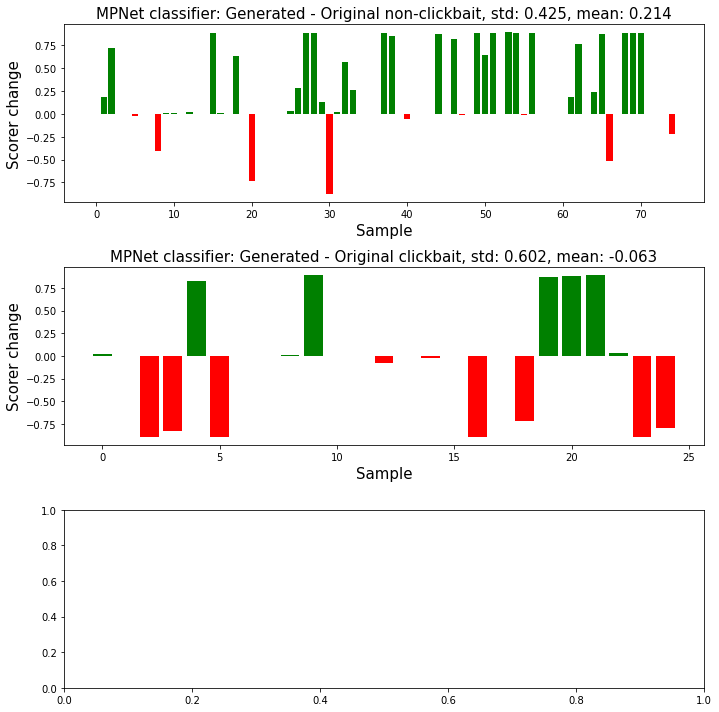

In [41]:
import matplotlib.pyplot as plt
generate_bar_plot(df_generated = df_pplm_test_max['clickbait_title_clickbait_score'], 
                    df_original = df_pplm_test_max['original_title_clickbait_score'], 
                    df_truth = df_pplm_test_max['truthClass'],
                    save_path = 'pplm/' + 'pplm_test.png')

In [42]:
df_pplm_test = pd.read_csv('pplm/df_clickbait_test')


In [43]:
reference = "".join(eval(webis_total['test'][0]['targetParagraphs']))
prediction = df_pplm_test_max['clickbait_title_clickbait_score']
            #df_original = df_pplm_test_max['original_title_clickbait_score']

In [44]:
# class_labels = [0.0, 0.33, 0.66, 1.0]
# df_pplm_test_class_label = {}
# for class_label in class_labels:
#     print(class_labels)
#     df_pplm_test_class_label[f'class_label_{class_label}_subset_25'] = pd.read_csv(f'pplm/df_clickbait_test_class_label_{class_label}_subset_25.csv') 
#     # print(df_pplm_test_class_label[f'class_label_{class_label}_subset_25'].keys())
#     df_pplm_test_class_label[f'class_label_{class_label}_subset_25'] = get_classifier_results(original_dataset = webis_total['test'],
#                                             pplm_dataset=df_pplm_test_class_label[f'class_label_{class_label}_subset_25'],
#                                             subset=25)
#     df_pplm_test_class_label[f'class_label_{class_label}_subset_25'] = pd.DataFrame(find_pplm_max_results(df_pplm_test_class_label[f'class_label_{class_label}_subset_25']))

#     generate_bar_plot(df_generated = df_pplm_test_class_label[f'class_label_{class_label}_subset_25']['clickbait_title_clickbait_score'], 
#                     df_original = df_pplm_test_class_label[f'class_label_{class_label}_subset_25']['original_title_clickbait_score'], 
#                     df_truth = df_pplm_test_class_label[f'class_label_{class_label}_subset_25']['truthClass'],
#                     save_path = f'pplm_test_class_label_{class_label}.png')

0.4
pplm/df_clickbait_test_stepsize_0.4_subset_25.csv
0
10
20
0.8
pplm/df_clickbait_test_stepsize_0.8_subset_25.csv
0
10
20
1.2
pplm/df_clickbait_test_stepsize_1.2_subset_25.csv
0
10
20
1.6
pplm/df_clickbait_test_stepsize_1.6_subset_25.csv
0
10
20
2.0
pplm/df_clickbait_test_stepsize_2.0_subset_25.csv
0
10
20
4.0
pplm/df_clickbait_test_stepsize_4.0_subset_25.csv
0
10
20
6.0
pplm/df_clickbait_test_stepsize_6.0_subset_25.csv
0
10
20
8.0
pplm/df_clickbait_test_stepsize_8.0_subset_25.csv
0
10
20
10.0
pplm/df_clickbait_test_stepsize_10.0_subset_25.csv
0
10
20
12.0
pplm/df_clickbait_test_stepsize_12.0_subset_25.csv
0
10
20
15.0
pplm/df_clickbait_test_stepsize_15.0_subset_25.csv
0
10
20
17.0
pplm/df_clickbait_test_stepsize_17.0_subset_25.csv
0
10
20
20.0
pplm/df_clickbait_test_stepsize_20.0_subset_25.csv
0
10
20
25.0
pplm/df_clickbait_test_stepsize_25.0_subset_25.csv
0
10
20
30.0
pplm/df_clickbait_test_stepsize_30.0_subset_25.csv
0
10
20
40.0
pplm/df_clickbait_test_stepsize_40.0_subset_25.csv


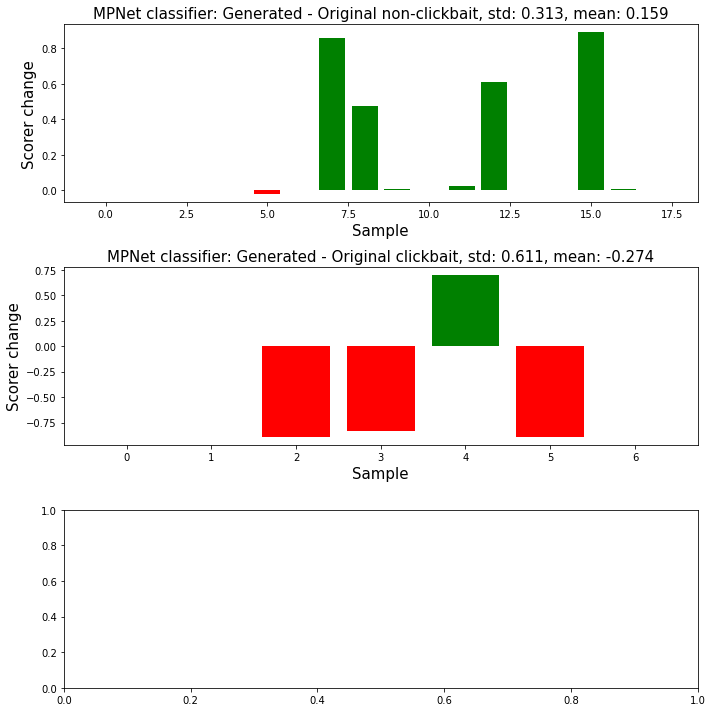

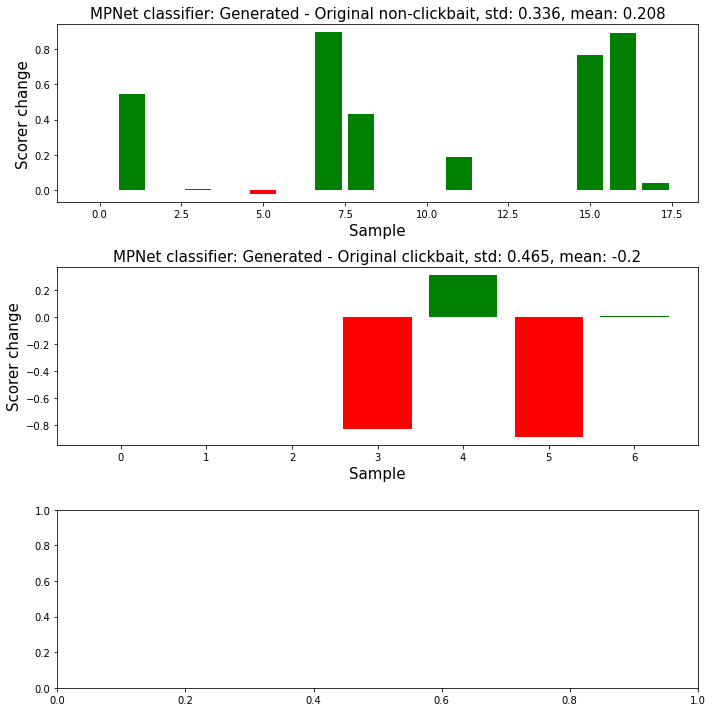

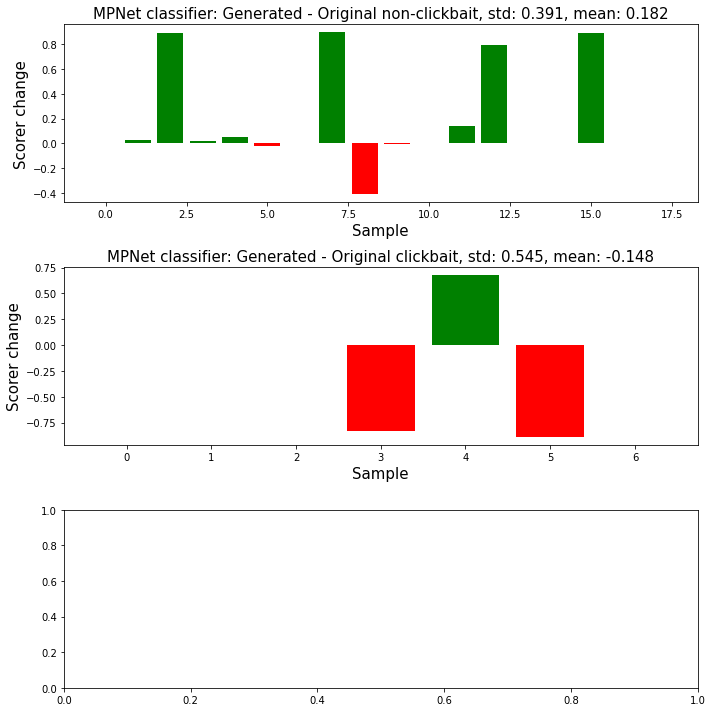

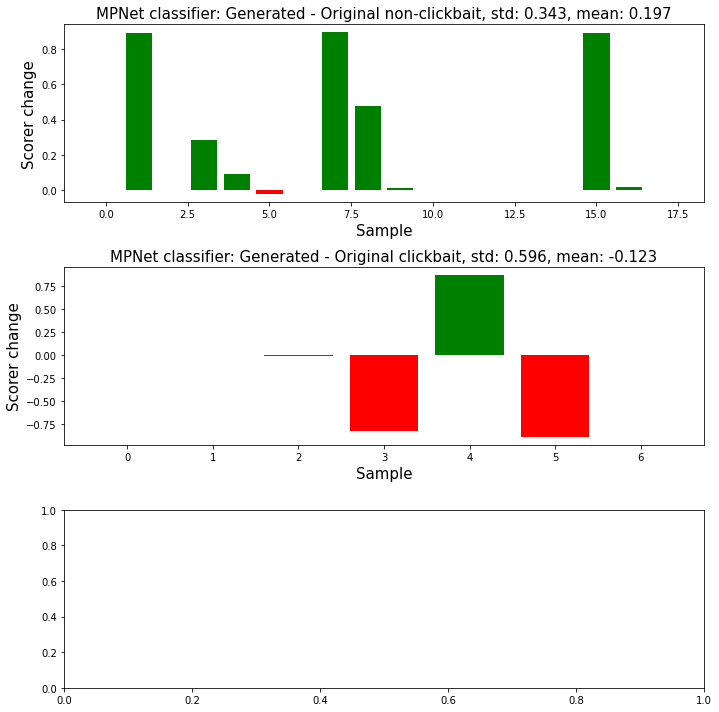

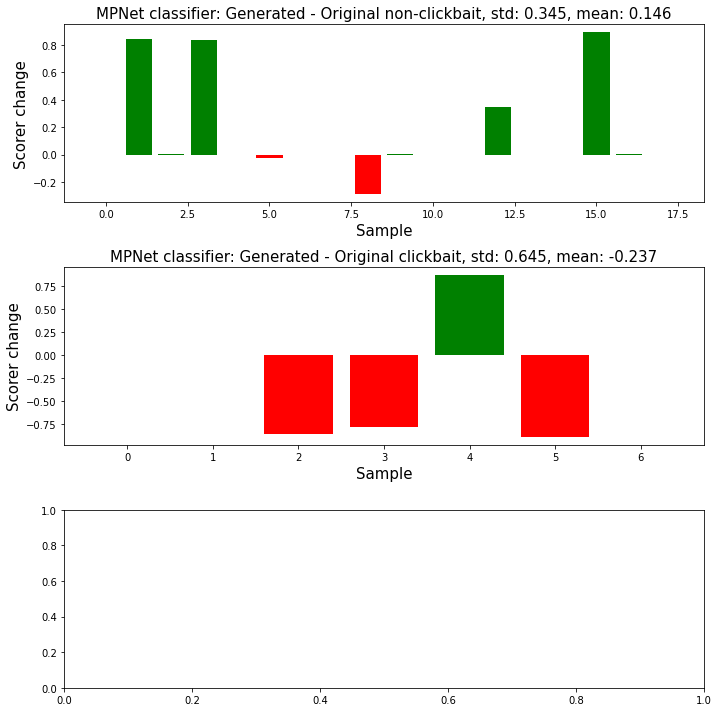

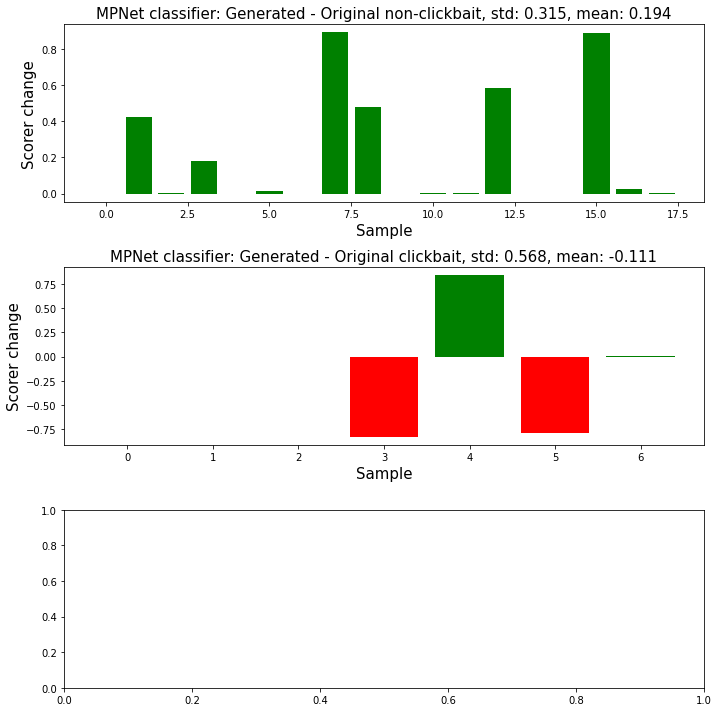

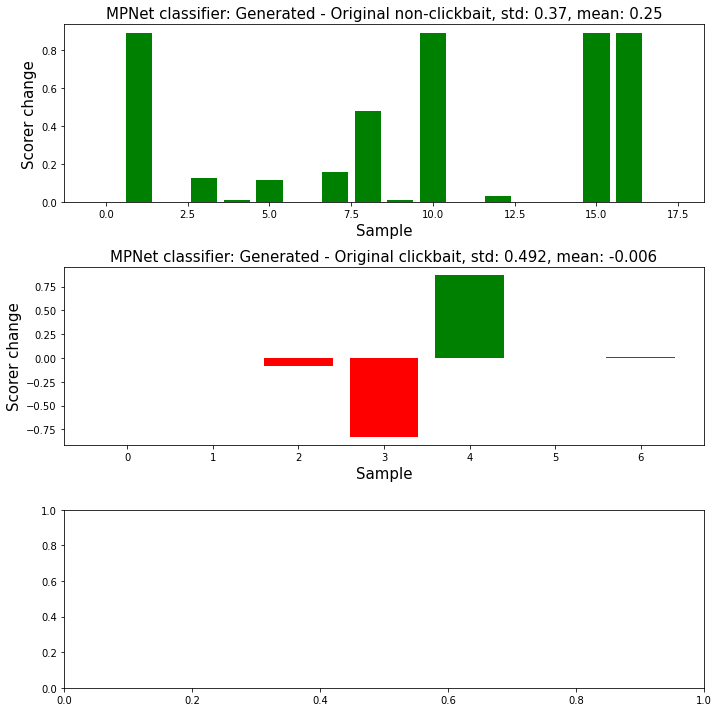

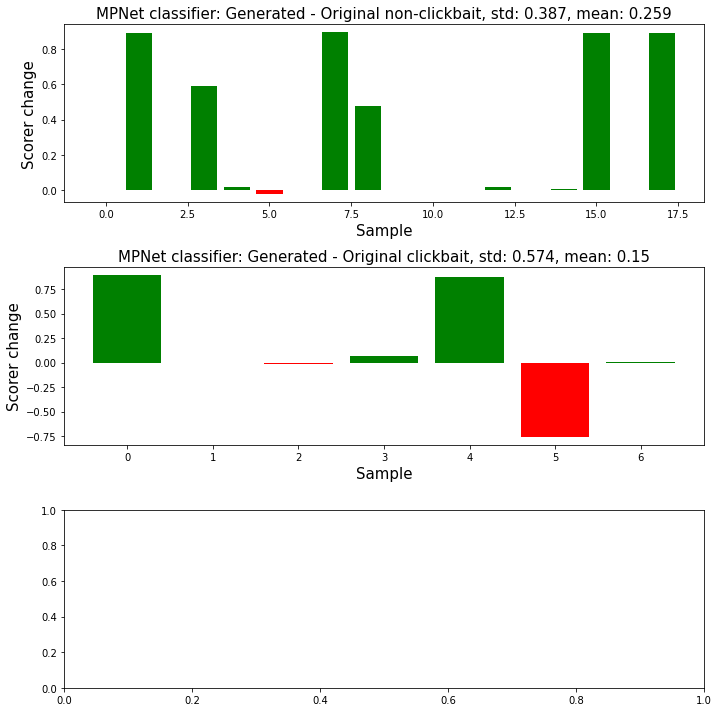

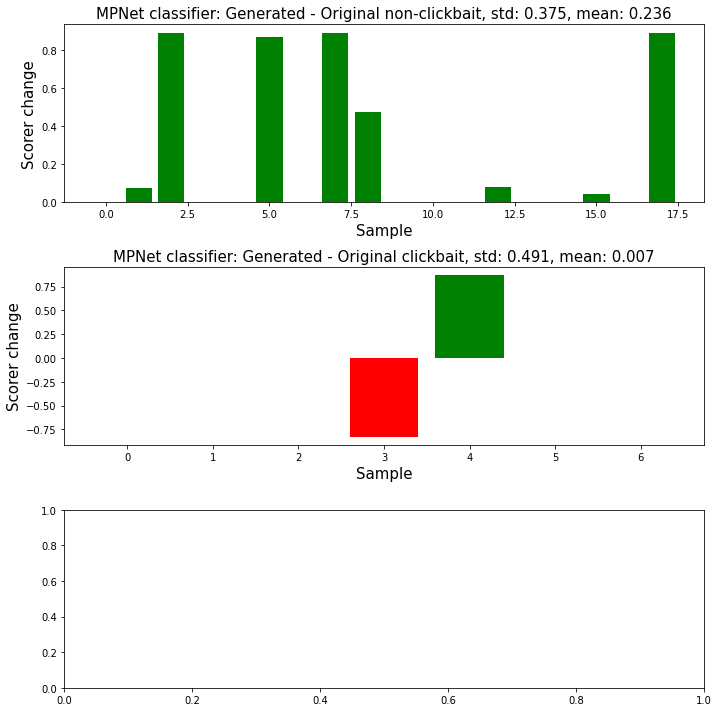

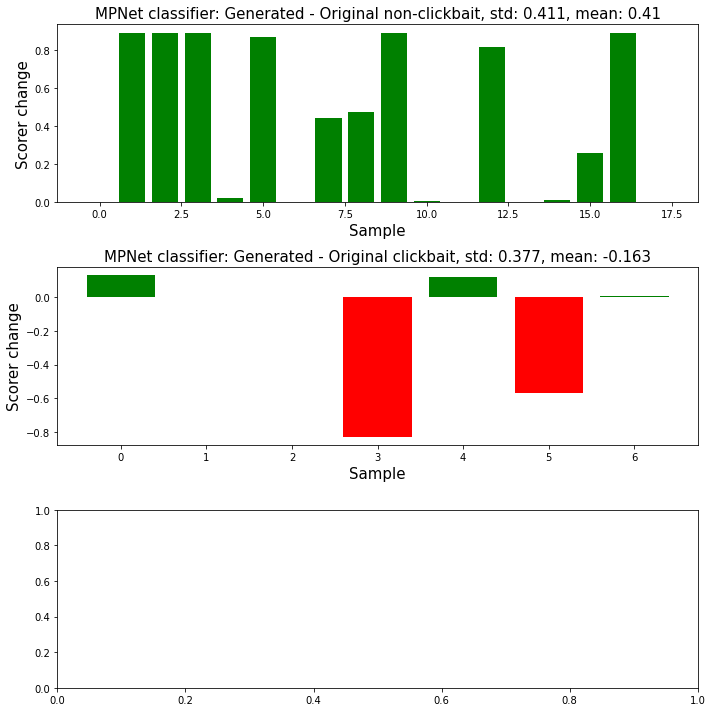

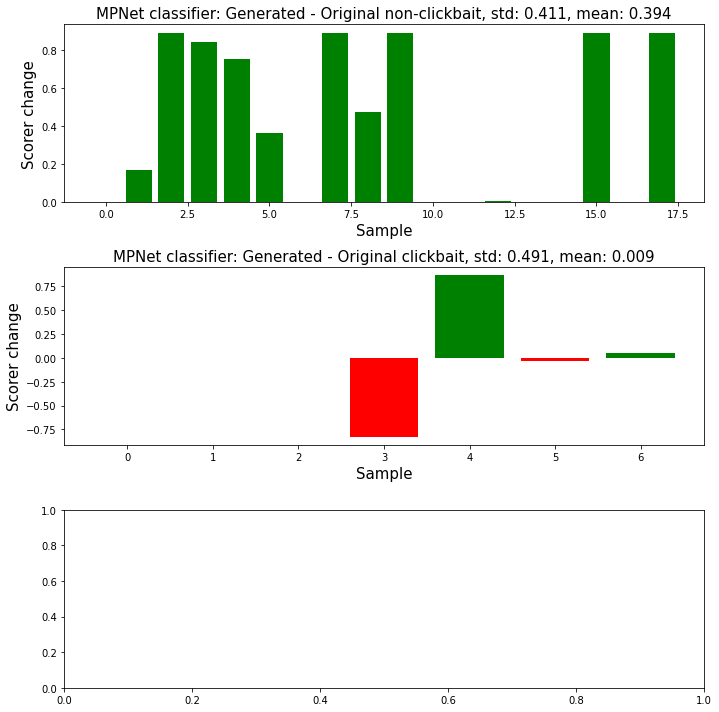

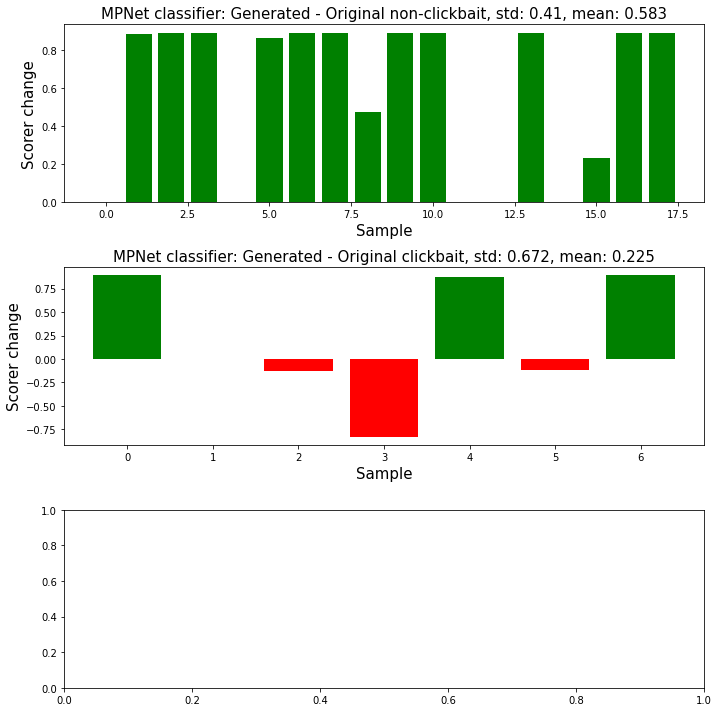

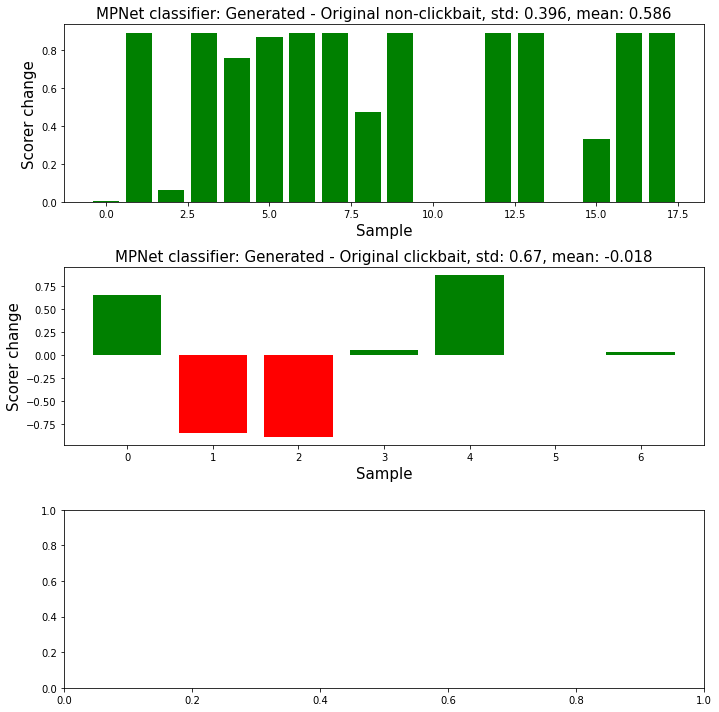

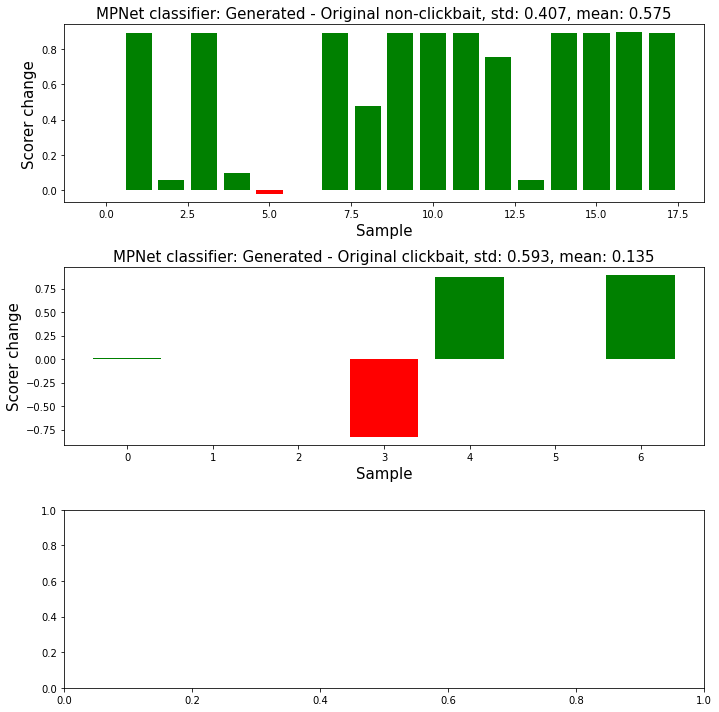

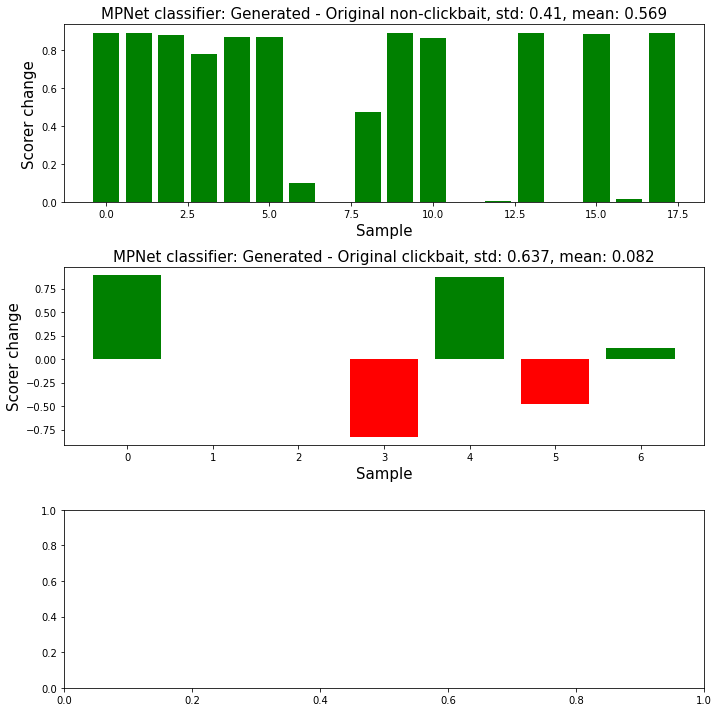

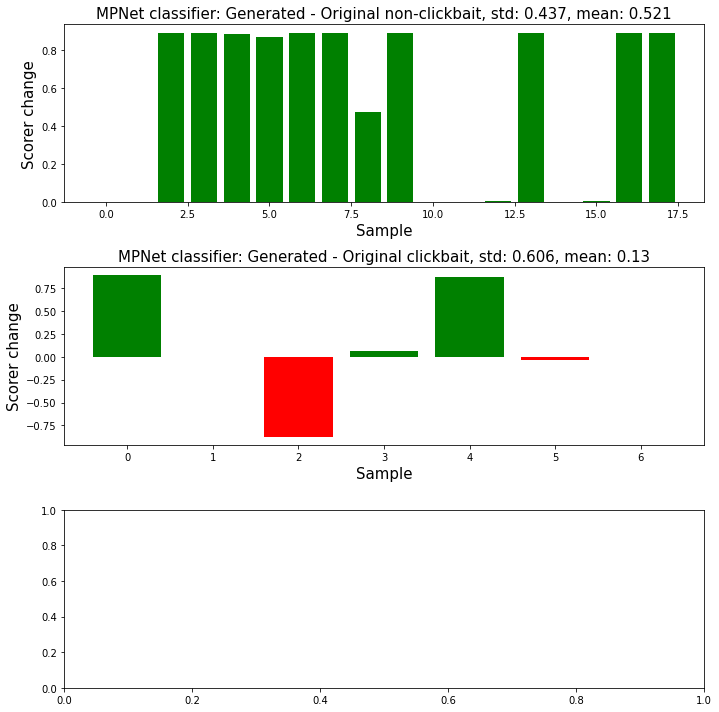

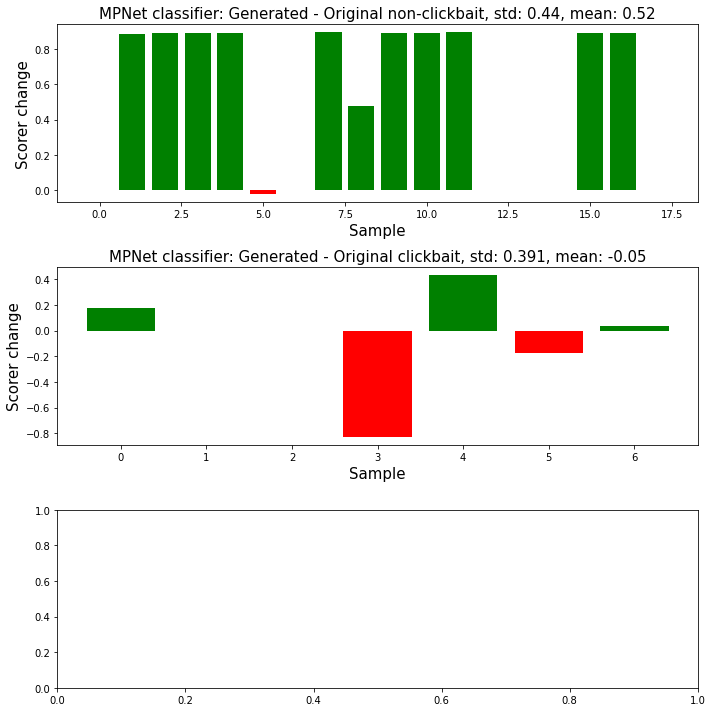

In [45]:
import matplotlib.pyplot as plt
stepsize_array = [0.4,0.8,1.2,1.6,2.0,4.0,6.0,8.0,10.0,12.0,15.0,17.0,20.0,25.0,30.0,40.0,50.0]

df_pplm_test_stepsize = {}
for stepsize in stepsize_array:
    print(stepsize)
    print(f'pplm/df_clickbait_test_stepsize_{stepsize}_subset_25.csv')
    df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25'] = pd.read_csv(f'pplm/df_clickbait_test_stepsize_{stepsize}_subset_25.csv') 
    # print(df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25'].keys())
    df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25'] = get_classifier_results(original_dataset = webis_total['test'],
                                            pplm_dataset=df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25'],
                                            subset=25)
    df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25'] = pd.DataFrame(find_pplm_max_results(df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']))

    generate_bar_plot(df_generated = df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']['clickbait_title_clickbait_score'], 
                    df_original = df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']['original_title_clickbait_score'], 
                    df_truth = df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']['truthClass'],
                    save_path = 'pplm/' + f'pplm_test_stepsize_{stepsize}.png')

In [46]:
df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']

,clickbait_title_clickbait_score,original_title_clickbait_score,clickbait_title,original_title,truthClass
0,0.013112,0.012937,0.013112,Johnny Manziel Says Top Pick in Draft Myles Ga...,0
1,0.896614,0.013666,0.896614,Fabio: California Is a 'Mess' Because of Liber...,0
2,0.187939,0.012977,0.187939,"Jimmy Butler wants to return, hopes Bulls keep...",1
3,0.904030,0.012913,0.904030,Mitchell Trubisky booed at United Center durin...,0
4,0.905086,0.013884,0.905086,It's Not Enough to Give Employees Flexible Wor...,0
5,0.905013,0.017973,0.905013,"Out Of 15 Lakh Registered Companies In India, ...",0
6,0.013222,0.034761,0.013222,Tense moment plane lands without wheel,0
7,0.905020,0.904862,0.905020,Stars Who Got Their Start on Soap Operas,1
8,0.013033,0.012970,0.013033,Trump: My first 100 days are 'just about the m...,0
9,0.905184,0.012976,0.905184,U.S. wants more U.N. sanctions over North Kore...,0


In [50]:
keys_arrays = ['original_clickbait', 'generated_clickbait', 'original_non_clickbait', 'generated_non_clickbait']
array_clickbait_score_per_hyperparameter = {
    k : [] for k in keys_arrays
}
for stepsize in stepsize_array:
    index_truth_class = df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']['truthClass']
    array_clickbait_score_per_hyperparameter['original_clickbait'].append(
        df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']['original_title_clickbait_score'][index_truth_class == 1].mean())
    array_clickbait_score_per_hyperparameter['generated_clickbait'].append(
        df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']['clickbait_title_clickbait_score'][index_truth_class == 1].mean())
    array_clickbait_score_per_hyperparameter['original_non_clickbait'].append(
        df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']['original_title_clickbait_score'][index_truth_class == 0].mean())
    array_clickbait_score_per_hyperparameter['generated_non_clickbait'].append(
        df_pplm_test_stepsize[f'stepsize_{stepsize}_subset_25']['clickbait_title_clickbait_score'][index_truth_class == 0].mean())



In [51]:
array_clickbait_score_per_hyperparameter

{'original_clickbait': [0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735],
 'generated_clickbait': [0.243512051046959,
  0.3172224619026695,
  0.3690256932750344,
  0.3943421401615654,
  0.2800675053149462,
  0.4063942368541445,
  0.5110792009426015,
  0.6672081203599062,
  0.5237359574862889,
  0.35378480955426184,
  0.5264529823990804,
  0.7420508866863591,
  0.49905320310166906,
  0.6518329387264592,
  0.5987104069707649,
  0.6472161573224834,
  0.4666350595653057],
 'original_non_clickbait': [0.03770486172288656,
  0.03770486172288656,
  0.03770486172288656,
  0.03770486172288656,
  0.03770486172288656,
  0.03770486172288656,
  0.03770486172288656,
  0.0377048617228

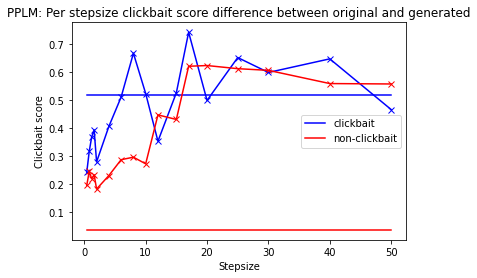

In [52]:
# for k, v in array_clickbait_score_per_hyperparameter['original_clickbait'].items():
import matplotlib.pyplot as plt
color_plot = {
    'clickbait' : 'blue',
    'non-clickbait' : 'red'
}
k='clickbait'
plt.plot(stepsize_array, array_clickbait_score_per_hyperparameter['original_clickbait'], '-', 
            label=k, color = color_plot[k])
plt.plot(stepsize_array, array_clickbait_score_per_hyperparameter['generated_clickbait'], 'x-', 
            color = color_plot[k])
k='non-clickbait'
plt.plot(stepsize_array, array_clickbait_score_per_hyperparameter['original_non_clickbait'], '-', 
            label=k, color = color_plot[k])
plt.plot(stepsize_array, array_clickbait_score_per_hyperparameter['generated_non_clickbait'], 'x-', 
            color = color_plot[k])

title = 'PPLM: Per stepsize clickbait score difference between original and generated'
plt.title(title,wrap=True)
plt.xlabel('Stepsize')
plt.ylabel('Clickbait score')
plt.legend()
plt.savefig('pplm/' + title + '.png')
plt.show()

In [53]:
# df_pplm_train = pd.read_csv('pplm/df_clickbait_train.csv')
# df_pplm_train = get_classifier_results(original_dataset = webis_total['train'], 
#                                         pplm_dataset = df_pplm_train,
#                                         subset=100)

In [54]:
# df_pplm_train.head()

In [55]:
# df_pplm_valid = pd.read_csv('pplm/df_clickbait_valid.csv')
# df_pplm_valid = get_classifier_results(original_dataset = webis_total['validation'], 
#                                         pplm_dataset = df_pplm_valid,
#                                         subset=100)

In [56]:
# !ls pplm

# Analyzing Fudge

In [57]:
!ls fudge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 df_clickbait_test_condition_lambda_25.0_subset_300
 df_clickbait_test_lambda_0.0_subset_25
 df_clickbait_test_lambda_100.0_subset_25
 df_clickbait_test_lambda_10.0_subset_25
 df_clickbait_test_lambda_1.0_subset_25
 df_clickbait_test_lambda_120.0_subset_25
 df_clickbait_test_lambda_130.0_subset_25
 df_clickbait_test_lambda_140.0_subset_25
 df_clickbait_test_lambda_150.0_subset_25
 df_clickbait_test_lambda_200.0_subset_25
 df_clickbait_test_lambda_20.0_subset_25
 df_clickbait_test_lambda_30.0_subset_25
 df_clickbait_test_lambda_40.0_subset_25
 df_clickbait_test_lambda_50.0_subset_25
 df_clickbait_test_lambda_5.0_subset_25
 df_clickbait_test_lambda_60.0_subset_25
 df_cl

In [58]:
def get_classifier_results_fudge(original_dataset = None, 
                            fudge_dataset = None,
                            subset=100):

    fudge_results = {
        'id' : [],
        'original_title_clickbait_score' : [],
        'clickbait_title_clickbait_score' : [],
        'truthClass' : [],
    }
    for chosen_index in range(subset):

        if(chosen_index % 10 == 0):
            print(chosen_index)


        fudge_results['id'].append(original_dataset['id'][chosen_index])

        chosen_column = 'clickbait_title'
        result = rate_title(input_text = {
                            'postText' : fudge_dataset.iloc[chosen_index][chosen_column], 
                            'truthClass' : original_dataset['truthClass'][chosen_index]
                        },
                    model=classifier_model.to('cuda'),
                    tokenizer=classifier_tokenizer,
                    device='cuda'
                    )
        fudge_results['clickbait_title_clickbait_score'].append(result['predicted_class'])

        chosen_column = 'original_title'
        result = rate_title(input_text = {
                            'postText' : fudge_dataset.iloc[chosen_index][chosen_column], 
                            'truthClass' : original_dataset['truthClass'][chosen_index]
                        },
                    model=classifier_model.to('cuda'),
                    tokenizer=classifier_tokenizer,
                    device='cuda'
                    )
        fudge_results['original_title_clickbait_score'].append(result['predicted_class'])

        fudge_results['truthClass'].append(original_dataset['truthClass'][chosen_index])

    for key in fudge_results.keys():
        fudge_dataset[key] = pd.Series(fudge_results[key])

    return fudge_dataset


In [59]:
df_fudge_test = pd.read_csv('fudge/fudge_df_clickbait_test.csv') 
df_fudge_test = get_classifier_results_fudge(original_dataset = webis_total['test'],
                                            fudge_dataset=df_fudge_test,
                                            subset=100)
df_fudge_test.head()

0
10
20
30
40
50
60
70
80
90


,original_title,clickbait_title,article_content,id,original_title_clickbait_score,clickbait_title_clickbait_score,truthClass
0,Johnny Manziel Says Top Pick in Draft Myles Ga...,Former Cleveland quarterback Johnny Manziel s...,"[""Johnny Manziel approves of the Cleveland Bro...",858426904239497216,0.012937,0.012977,0
1,Fabio: California Is a 'Mess' Because of Liber...,"""The Great Californian Syndrome"" is happening...","['Fabio, the Italian-born male model who has a...",858416350540201984,0.013666,0.547667,0
2,"Jimmy Butler wants to return, hopes Bulls keep...",Chicago Bulls' Jimmy Butler says he wants to ...,"[""CHICAGO -- All-Star swingman Jimmy Butler kn...",858364015260704768,0.012977,0.013030,1
3,Mitchell Trubisky booed at United Center durin...,Chicago Bears second overall pick Mitchell Tr...,['CHICAGO -- New Bears quarterback Mitchell Tr...,858335817693102080,0.012913,0.013022,0
4,It's Not Enough to Give Employees Flexible Wor...,The world didn't know what to make of her sch...,"['Six months after her baby was born, Amanda S...",858326196282679296,0.013884,0.166332,0


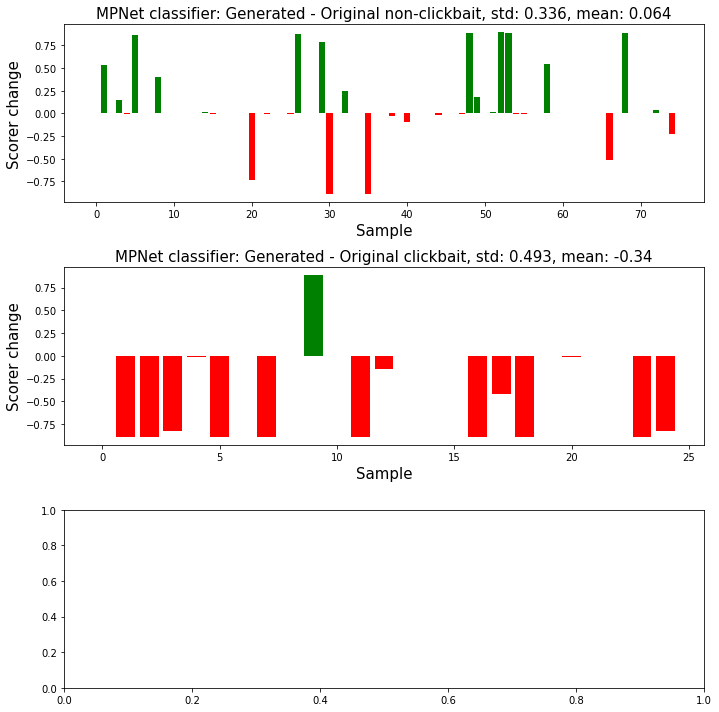

In [60]:
generate_bar_plot(df_generated = df_fudge_test['clickbait_title_clickbait_score'], 
                    df_original = df_fudge_test['original_title_clickbait_score'], 
                    df_truth = df_fudge_test['truthClass'],
                    save_path = 'fudge/' + 'fudge_test.png')

In [61]:
# df_fudge_train = pd.read_csv('fudge/fudge_df_clickbait_train.csv') 
# df_fudge_train = get_classifier_results_fudge(original_dataset = webis_total['train'],
#                                             fudge_dataset=df_fudge_train,
#                                             subset=100)
# df_fudge_train.head()

In [62]:
# df_fudge_valid = pd.read_csv('fudge/fudge_df_clickbait_valid.csv') 
# df_fudge_valid = get_classifier_results_fudge(original_dataset = webis_total['validation'],
#                                             fudge_dataset=df_fudge_valid,
#                                             subset=100)
# df_fudge_valid.head()

Condition lambda is : 0.0
0
10
20
Condition lambda is : 1.0
0
10
20
Condition lambda is : 5.0
0
10
20
Condition lambda is : 10.0
0
10
20
Condition lambda is : 20.0
0
10
20
Condition lambda is : 30.0
0
10
20
Condition lambda is : 40.0
0
10
20
Condition lambda is : 50.0
0
10
20
Condition lambda is : 60.0
0
10
20
Condition lambda is : 70.0
0
10
20
Condition lambda is : 80.0
0
10
20
Condition lambda is : 90.0
0
10
20
Condition lambda is : 100.0
0
10
20
Condition lambda is : 120.0
0
10
20
Condition lambda is : 130.0
0
10
20
Condition lambda is : 140.0
0
10
20
Condition lambda is : 150.0
0
10
20
Condition lambda is : 200.0
0
10
20


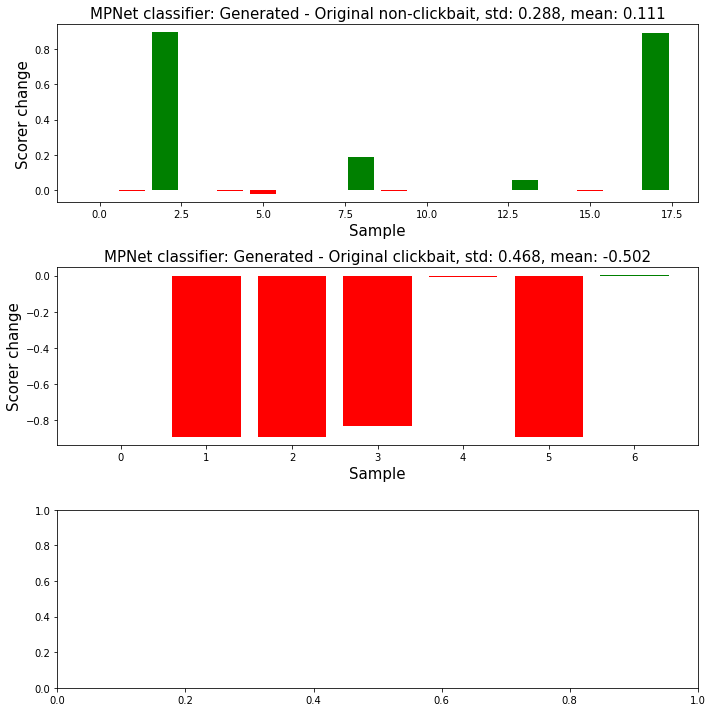

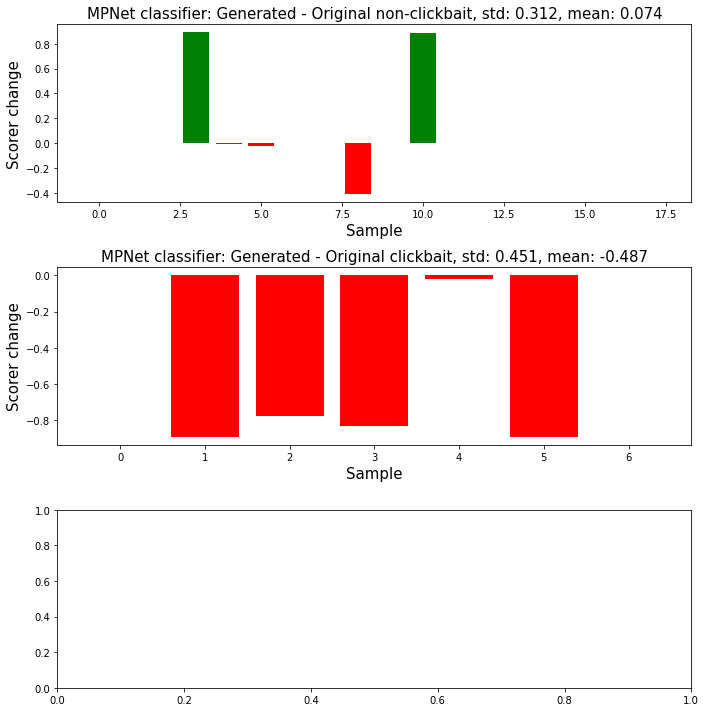

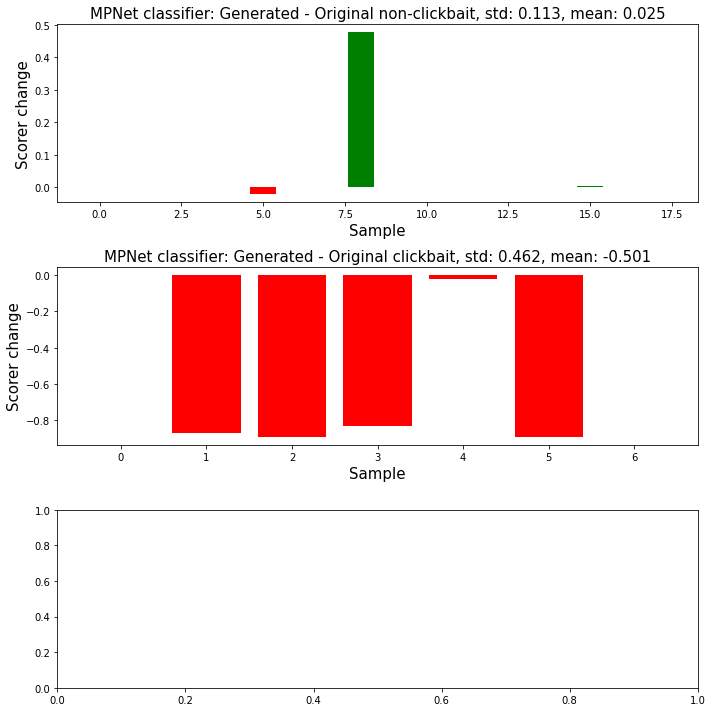

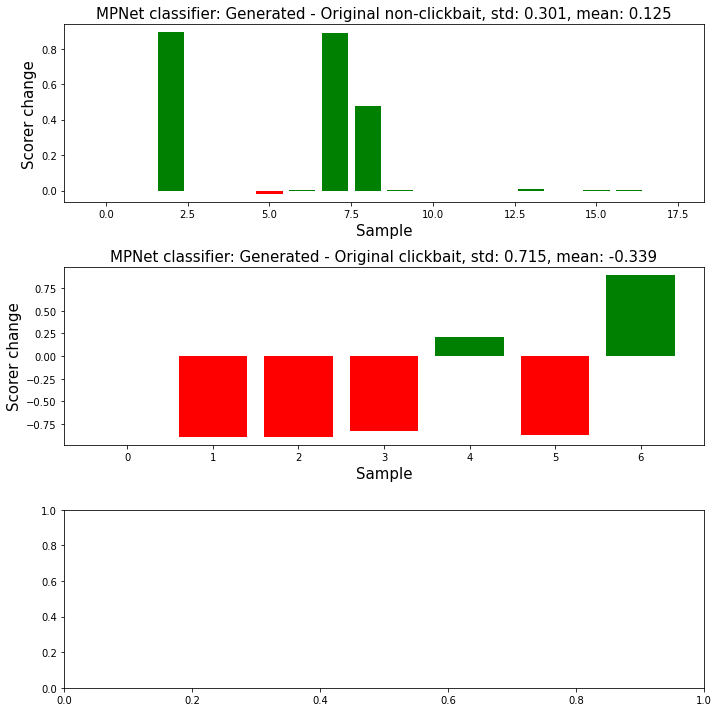

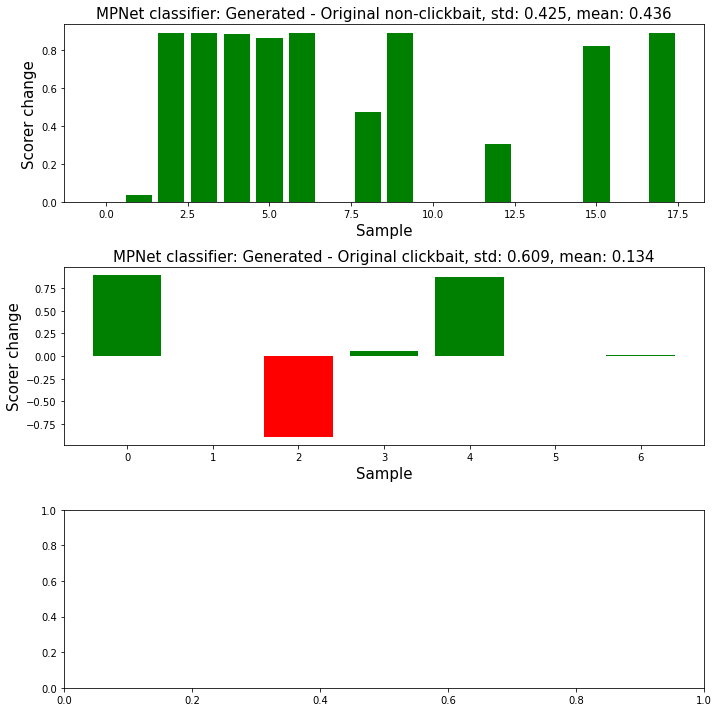

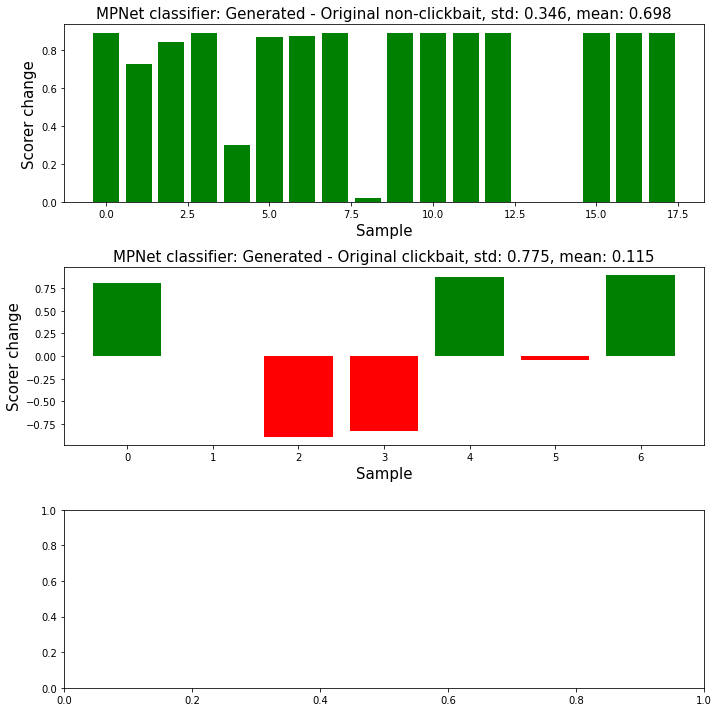

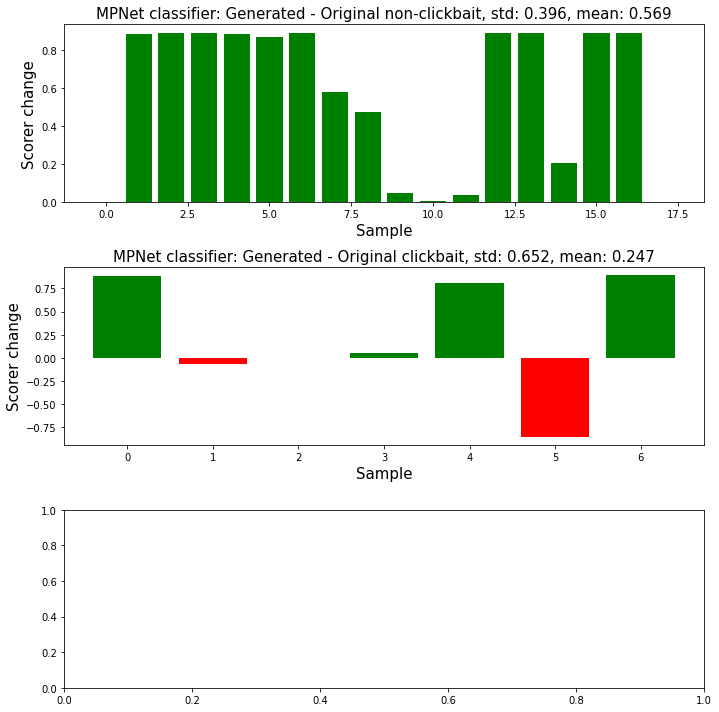

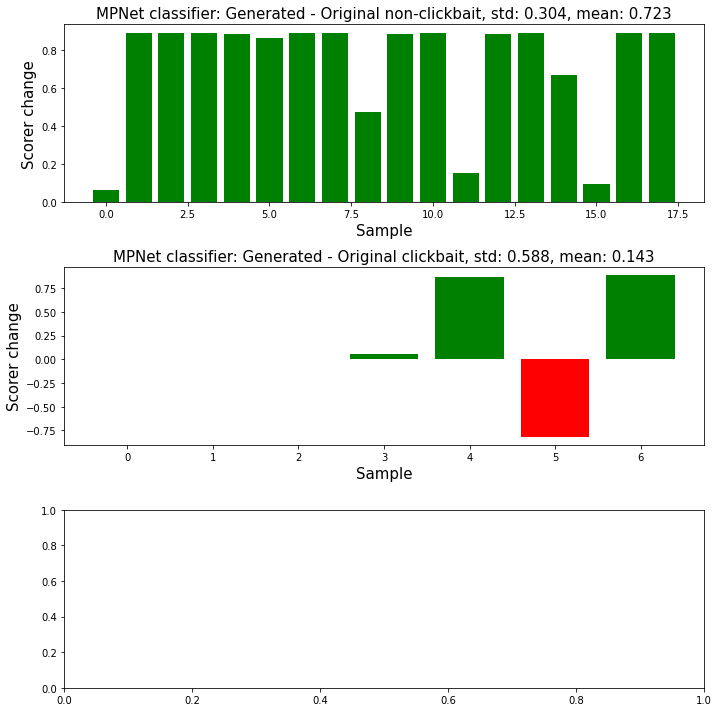

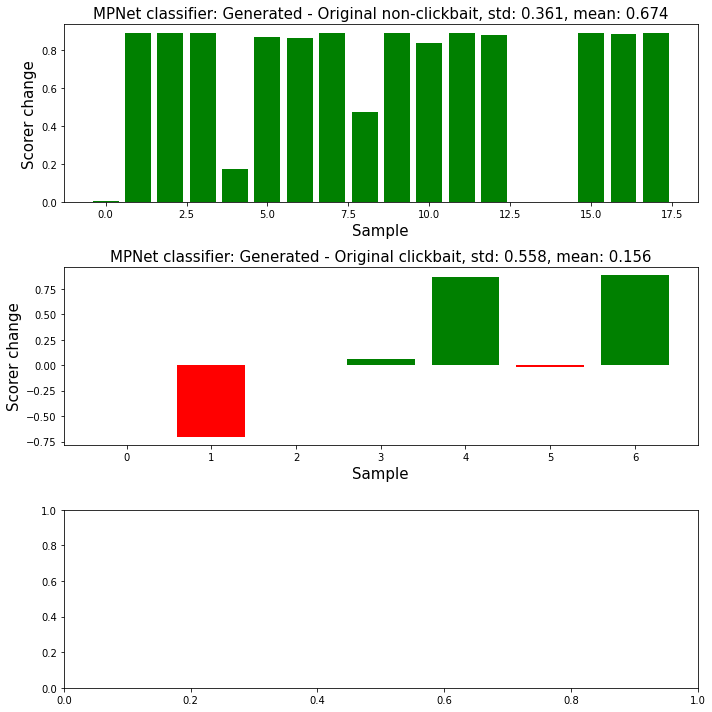

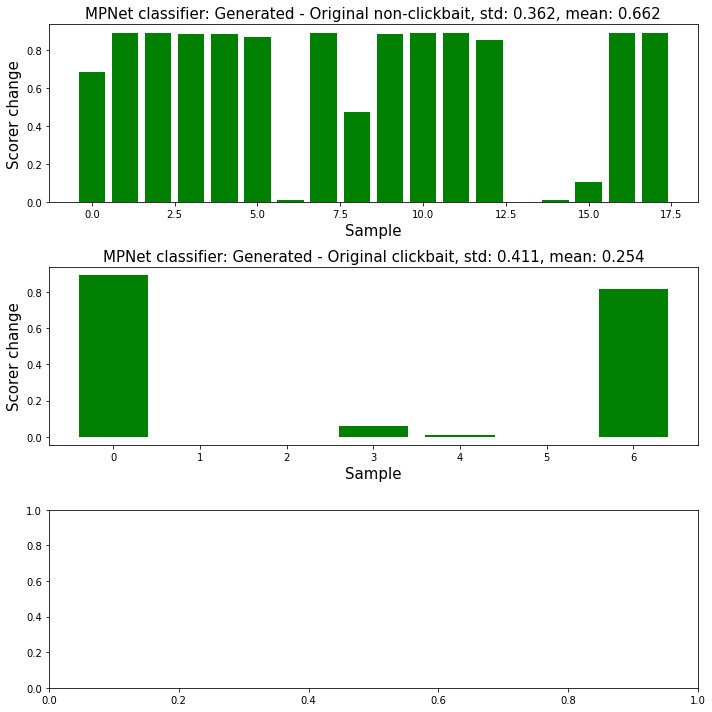

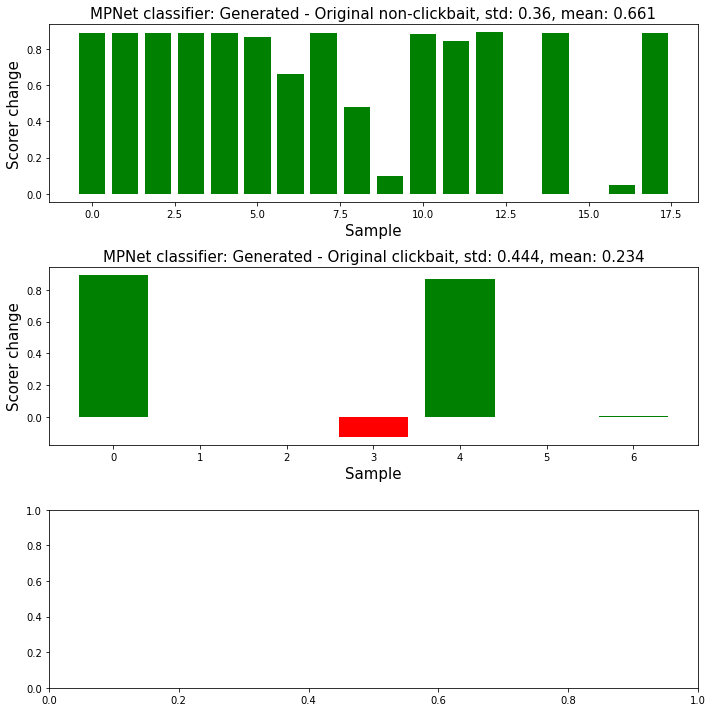

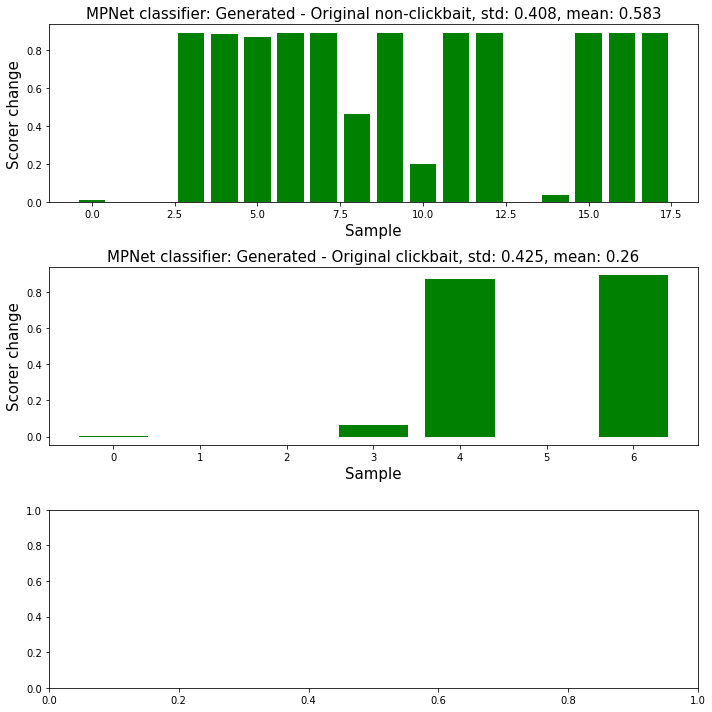

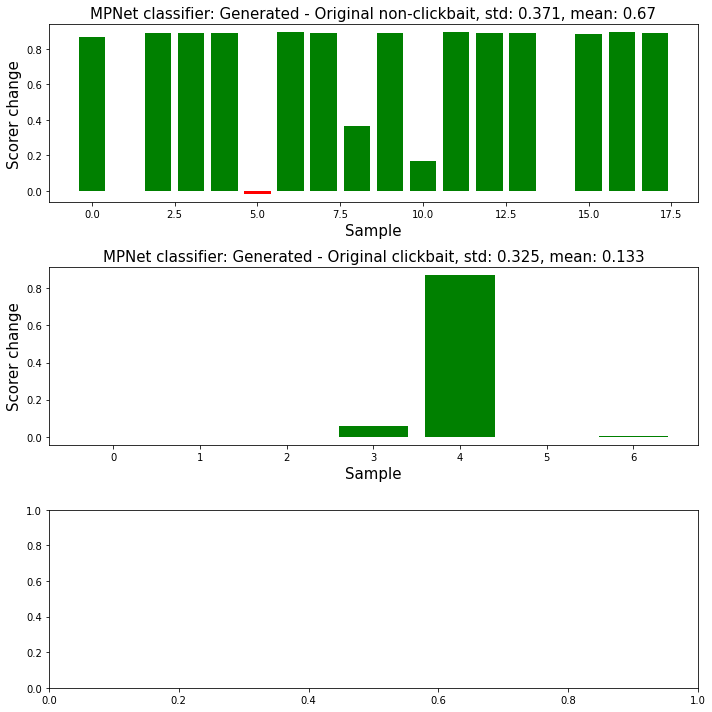

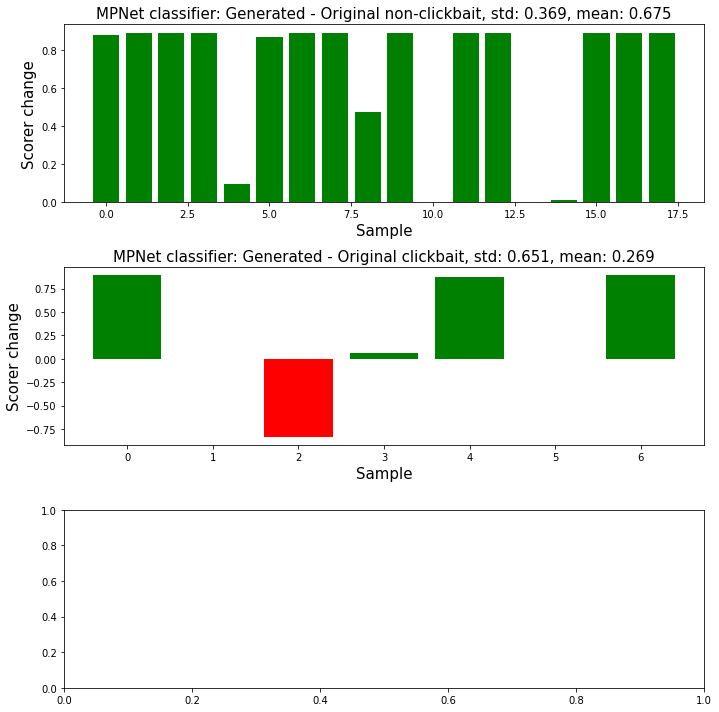

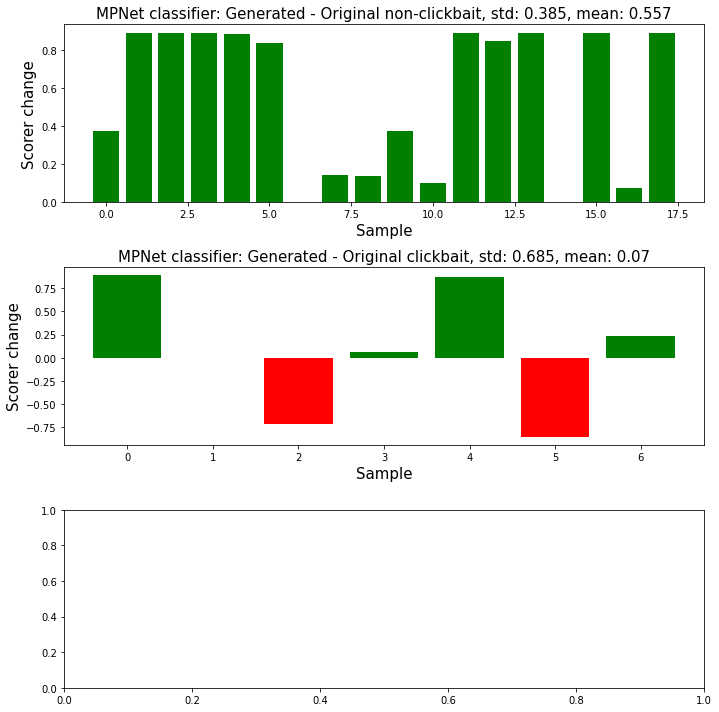

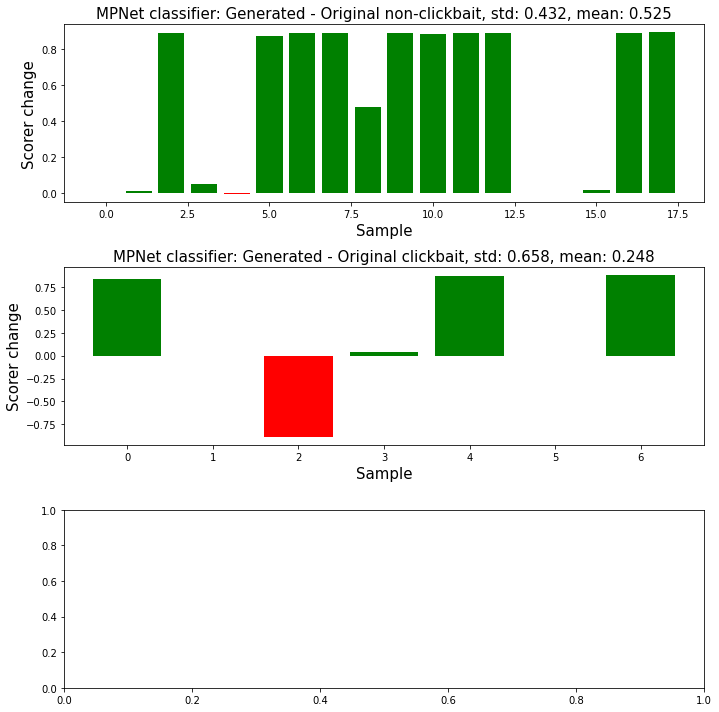

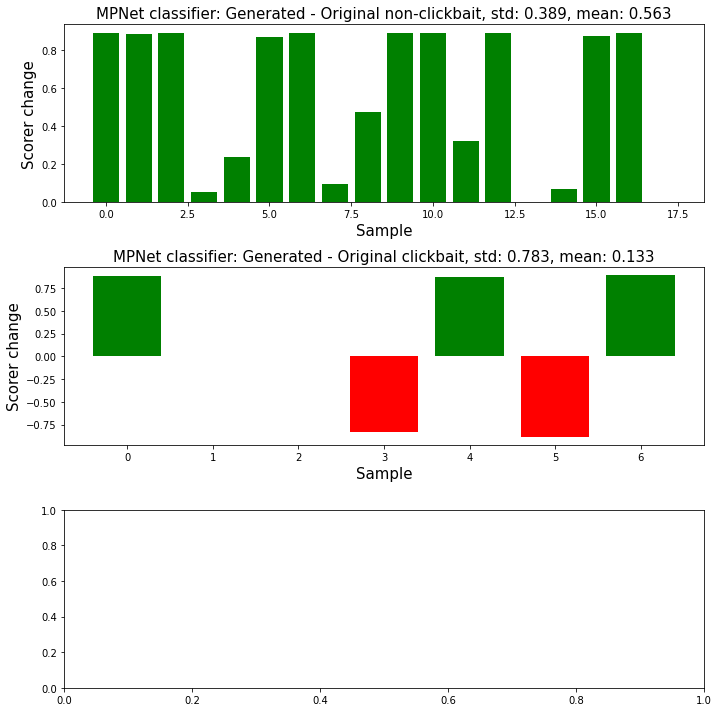

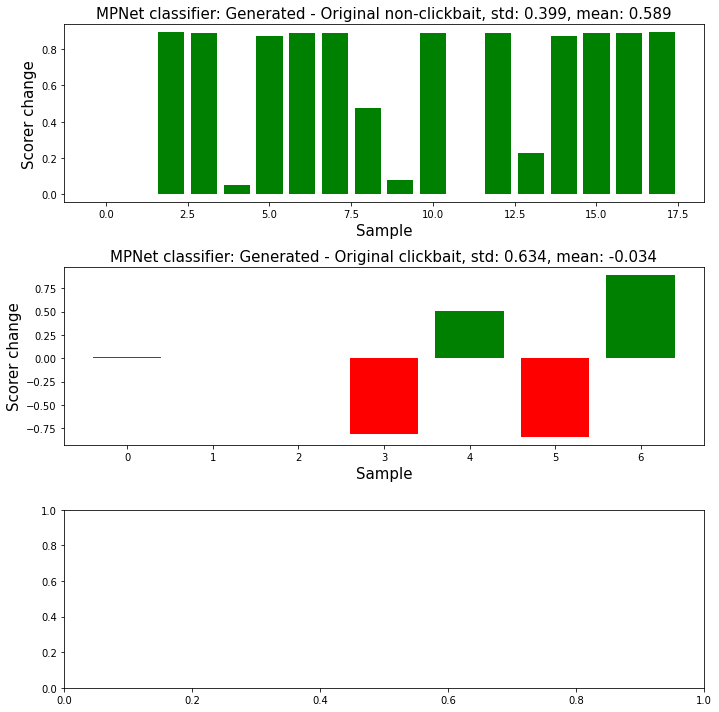

In [63]:
# condition_lambdas = [0.0, 1.0, 5.0, 50.0, 100.0, 200.0]
# condition_lambdas = [0.0, 1.0,5.0, 10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,200.0]

condition_lambdas = [0.0, 1.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0,
                     70.0, 80.0, 90.0, 100.0, 120.0, 130.0, 140.0, 150.0, 200.0]

df_fudge_test_condition_lambda = {}
for condition_lambda in condition_lambdas:
    print(f'Condition lambda is : {condition_lambda}')
    df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25'] = pd.read_csv(f'fudge/df_clickbait_test_lambda_{condition_lambda}_subset_25') 
    df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25'] = get_classifier_results_fudge(original_dataset = webis_total['test'],
                                            fudge_dataset=df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25'],
                                            subset=25)

    generate_bar_plot(df_generated = df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25']['clickbait_title_clickbait_score'], 
                    df_original = df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25']['original_title_clickbait_score'], 
                    df_truth = df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25']['truthClass'],
                    save_path = 'fudge/' + f'fudge_test_condition_lambda_{condition_lambda}.png')
# df_fudge_test.head()

In [64]:
keys_arrays = ['original_clickbait', 'generated_clickbait', 'original_non_clickbait', 'generated_non_clickbait']
array_clickbait_score_per_hyperparameter = {
    k : [] for k in keys_arrays
}

for condition_lambda in condition_lambdas:
    index_truth_class = df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25']['truthClass']
    array_clickbait_score_per_hyperparameter['original_clickbait'].append(
        df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25']['original_title_clickbait_score'][index_truth_class == 1].mean())
    array_clickbait_score_per_hyperparameter['generated_clickbait'].append(
        df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25']['clickbait_title_clickbait_score'][index_truth_class == 1].mean())
    array_clickbait_score_per_hyperparameter['original_non_clickbait'].append(
        df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25']['original_title_clickbait_score'][index_truth_class == 0].mean())
    array_clickbait_score_per_hyperparameter['generated_non_clickbait'].append(
        df_fudge_test_condition_lambda[f'condition_lambda_{condition_lambda}_subset_25']['clickbait_title_clickbait_score'][index_truth_class == 0].mean())



In [65]:
array_clickbait_score_per_hyperparameter

{'original_clickbait': [0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735,
  0.5170548505016735],
 'generated_clickbait': [0.015411692804523877,
  0.029922384103494033,
  0.01641718777162688,
  0.17784213806901658,
  0.6510032841137477,
  0.6315973213474665,
  0.7637163294213158,
  0.6603379124509436,
  0.6735229466908744,
  0.7709624671510288,
  0.7509694543800184,
  0.776948530493038,
  0.6504233432933688,
  0.7855713367462158,
  0.5867740724767957,
  0.7655448888295463,
  0.6500453391511526,
  0.48339275723057135],
 'original_non_clickbait': [0.03770486172288656,
  0.03770486172288656,
  0.03770486172288656,
  0.03770486172288656,
  0.03770486172288656,
  0.0377048617

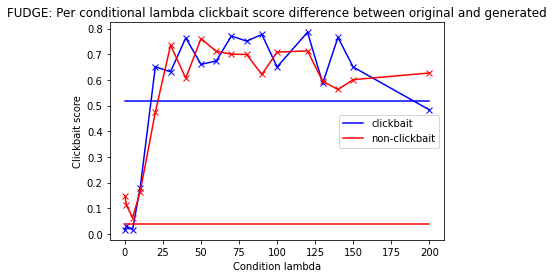

In [66]:
# for k, v in array_clickbait_score_per_hyperparameter['original_clickbait'].items():
import matplotlib.pyplot as plt
color_plot = {
    'clickbait' : 'blue',
    'non-clickbait' : 'red'
}
k='clickbait'
plt.plot(condition_lambdas, array_clickbait_score_per_hyperparameter['original_clickbait'], '-', 
            label=k, color = color_plot[k])
plt.plot(condition_lambdas, array_clickbait_score_per_hyperparameter['generated_clickbait'], 'x-', 
            color = color_plot[k])
k='non-clickbait'
plt.plot(condition_lambdas, array_clickbait_score_per_hyperparameter['original_non_clickbait'], '-', 
            label=k, color = color_plot[k])
plt.plot(condition_lambdas, array_clickbait_score_per_hyperparameter['generated_non_clickbait'], 'x-', 
            color = color_plot[k])

title = 'FUDGE: Per conditional lambda clickbait score difference between original and generated'
plt.title(title, wrap=True)
plt.xlabel('Condition lambda')
plt.ylabel('Clickbait score')
plt.legend()
plt.savefig('fudge/' + title + '.png')
plt.show()

# Analyzing Pegasus

In [69]:
!ls pegasus_clickbait_summarizer/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
test_pegasus_clickbait_classifier.csv
train_pegasus_clickbait_classifier.csv
validation_pegasus_clickbait_classifier.csv


In [72]:
pegasus_train = pd.read_csv('pegasus_clickbait_summarizer/train_pegasus_clickbait_classifier.csv')
pegasus_vlaid = pd.read_csv('pegasus_clickbait_summarizer/validation_pegasus_clickbait_classifier.csv')
pegasus_test = pd.read_csv('pegasus_clickbait_summarizer/test_pegasus_clickbait_classifier.csv')

In [73]:
pegasus_train.head()

,Unnamed: 0,Id,True title,True label,True Clickbait Score,Generated title,Generated Clickbait Score,id_code
0,0,0,Trump reverses course in 24 hours from Nato to...,0,0.012953,"Donald Trump's stunning reversals on Nato, Chi...",0.012930,8.525548e+17
1,1,1,President Trump says H&amp;R Block will be unh...,0,0.012934,Trump: H&R Block 'Probably Won't Be Happy' Wit...,0.012919,8.319399e+17
2,2,2,"London’s commuters have been tracked, and this...",1,0.902308,London's WiFi is being used to track your loca...,0.013480,8.318027e+17
3,3,3,Plastic surgeons often miss patients' mental d...,0,0.013242,Nearly one in 10 patients seeking facial plast...,0.013684,8.223681e+17
4,4,4,Fake news headline claims former President Oba...,0,0.013685,Fake News Story Claims Obama Might Make Treaso...,0.013059,8.345377e+17


In [240]:
pegasus_test['Generated Clickbait Score']
pegasus_test['True title']
pegasus_test['True label']

0     0
1     0
2     1
3     0
4     0
     ..
93    0
94    0
95    0
96    0
97    0
Name: True label, Length: 98, dtype: int64

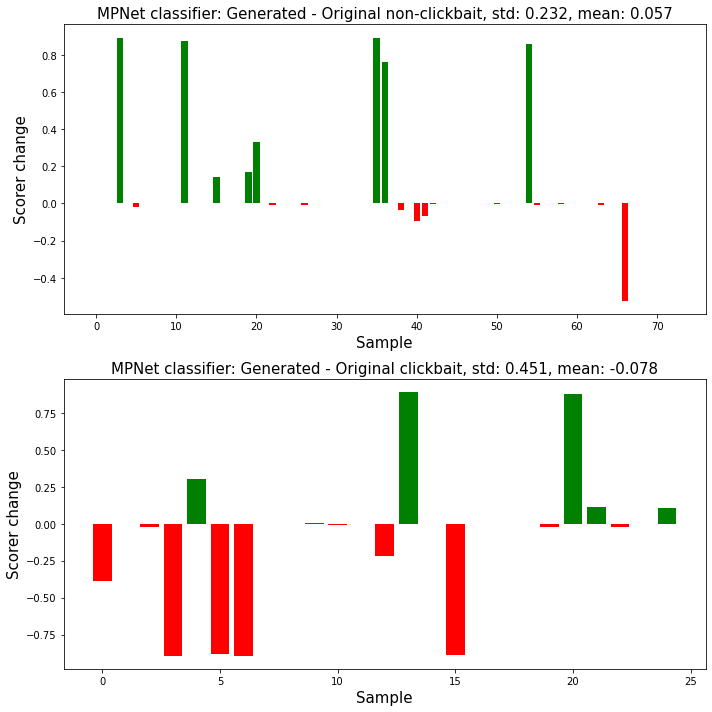

In [276]:
generate_bar_plot(df_generated = pegasus_test['Generated Clickbait Score'], 
                    df_original = pegasus_test['True Clickbait Score'], 
                    df_truth = pegasus_test['True label'],
                    save_path = 'pegasus_clickbait_summarizer/' + 'pegasus_test.png')

In [264]:
pegasus_test['True label'] == 0.0

0      True
1      True
2     False
3      True
4      True
      ...  
93     True
94     True
95     True
96     True
97     True
Name: True label, Length: 98, dtype: bool

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pegasus_non_clickbait_test = pd.read_csv('pegasus_clickbait_summarizer/test_pegasus_non_clickbait_classifier.csv')

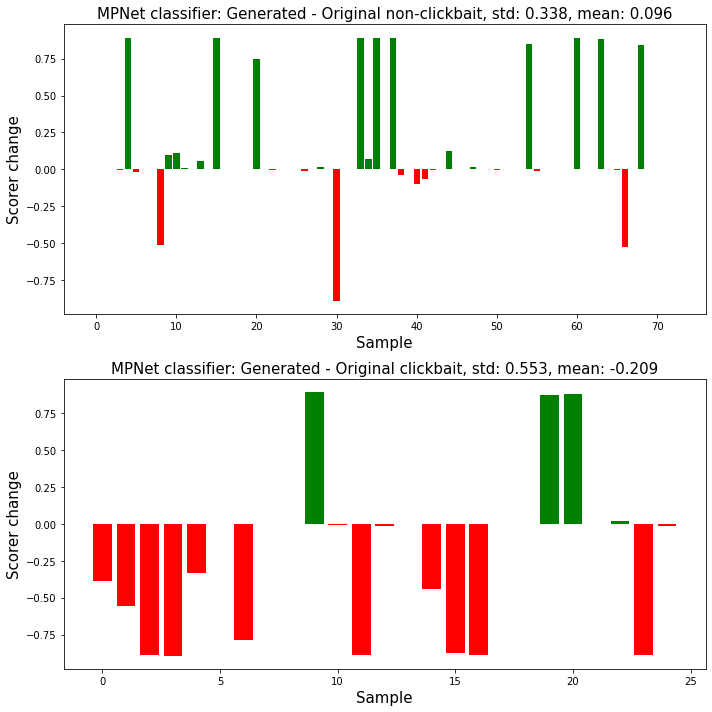

In [5]:
generate_bar_plot(df_generated = pegasus_non_clickbait_test['Generated Clickbait Score'], 
                    df_original = pegasus_non_clickbait_test['True Clickbait Score'], 
                    df_truth = pegasus_non_clickbait_test['True label'],
                    save_path = 'pegasus_clickbait_summarizer/' + 'pegasus_non_clickbait_test.png')